# BVP ammonia - sine wave, frequency of 1000 Hz

In [1]:
from munch import Munch
import numpy as np
from pyomo.environ import (ConcreteModel, Constraint, Objective, Var, Param, Reals, NonNegativeReals,
                           SolverFactory, value, sin, cos, Set, exp, Any, ConstraintList,
                           TransformationFactory, assert_optimal_termination, RangeSet, maximize)
from pyomo.dae import ContinuousSet, DerivativeVar
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from scipy import signal
from tqdm import tqdm 
# import idaes
from scipy.optimize import minimize
import time
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors
import math
from IPython.display import Image, display
from tqdm import tqdm
from scipy.interpolate import interp1d
from pyomo.core.expr.visitor import identify_variables
from pyomo.core.expr import differentiate
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import Akima1DInterpolator


# import watertap

In [2]:
class Params:
    """
    Declares reaction system and CSTR model parameters
    """
    
    def __init__(self,  T = 593.15, # K
                        T_orig = 593.15, # K                                    
                        T_gas = 593.15, # K
                        T_ref = 1,
                        T_c = 500, # K
                        Q_in = 1, # cm3/s
                        Q_out = 1,
                        P = 50, # atm
                        R_e = 1.987e-3, # kcal/mol K
                        R_k = 8.31451e7, # g cm2/mol K s
                        R = 82.057, # cm3 atm/K mol
                        V = 1.0, # cm3
                        SDTOT = 2.6188e-9, # moles/cm2
                        RATIO_S = 0.02,                     
                        abyv = 1200, # cm2 catalyst/cm3 reac volume
                        MW_H = 1.00797, # g/mol
                        MW_N = 14.0067, # g/mol
                        MWON = 0, # g/mol
                        X_H2  = 3,                     
                        X_N2  = 1,                   
                        X_NH3 = 0, 
                        beta = np.array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]),
                        Stick = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
                        Isobaric = 0,
                        A = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1.56E19, 1.56E19, 1.56E19, 1.56E19, 1.56E19, \
                                      0, 0, 1.56E19]).reshape(16,1),
                        Stoic =  np.array([[1, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0],
                           [-1, 2, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0],
                           [0, 0, 2, 0, 0, 0, 0, -1, 0, -2, 0, 0, 0, 0, 0, 0, 0, 0],
                           [0, 0, 1, -1, 1, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0],
                           [0, 0, 1, 0, -1, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0],
                           [0, 1, 1, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0],
                           [0, 0, 0, 1, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, -1, 0],
                           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 2, 0, 0, 0, 0, -1, 0],
                           [0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 2, 0, 0, 0, -2, 0],
                           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 1, 0, -1, 0],
                           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, -1, 1, -1, 0],
                           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, -1, -1, 0],
                           [0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 1, 0, 0, -1, 0],
                           [0, -1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, -1, 0],
                           [0, 0, -1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, -1, 0],
                           [0, 0, 0, -1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, -1, 0],
                           [0, 0, 0, 0, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, -1, 0],
                           [0, 0, 0, 0, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, -1, 0],
                           [0, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, 1, 0, 0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 1, 0, 0, 0, 0, 0, 1],
                           [0, -1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, -1, 1]]),
                        StrainCoef = [-0.04, 0.0, 0.04],
                        Q_ref = 134.21,
                        Q_target = 134.21, # binding energy of Ru 
                        alpha = np.array([0.62036, 1, 0.17, 0.14, 0.41, 0.71, 0.62036, 1.057, 0.18, 0.14, 0.391, 0.708, 1.057]),
                        Qi_ref = np.array([-2.0779, 134.21, 57.4245, 12.2999, 45.8833, 82.5372, 9.451, 106.224, 58.0824, 22.6759, 
                        63.9298, 91.8554, 106.224]),
                        mb = [0.514, 0.581, 0.725, 0.608, 0.855,0.809, 0.553, 0.470,0.183, 0.346],
                        b = [48.6,28.0,25.5,27.5,40.6,26.5,27.7,22.3,18.0,20.1],
                 
                        # pMuTT Recalculated Terrace site thermodynamic data w/ Shizhong DFT calculations Tref = 298.15 K

                        # A_N2s1_h
                        A_N2s1_h = [3.88555607E+00, 2.25579107E-03, -6.74243181E-07, -1.56805094E-10, 8.86546530E-14, -7.99940790e+03, -1.58249660e+01],
                        # A_N2s1_l
                        A_N2s1_l = [-4.15269022E-01, 3.85284631E-02, -1.17383449E-04, 1.68785681E-07, -9.23186795E-11, -7.58237629e+03, 1.75988553e+00],
                        # A_Ns1_h
                        A_Ns1_h = [8.81592750E-01, 5.93998550E-03, -6.89025148E-06, 3.70304607E-09, -7.59376769E-13, -1.32276911e+04, -6.40687724e+00],
                        # A_Ns1_l
                        A_Ns1_l = [-6.26549307E-01, 3.10362616E-03, 5.83736827E-05, -1.81844809E-07, 1.56189066E-10, -1.29201483e+04, 1.50466373e+00],
                        # A_Hs1_h
                        A_Hs1_h = [-1.59446486E+00, 1.16296966E-02, -1.25644676E-05, 6.41488372E-09, -1.26617068E-12, -6.34177280e+03, 6.18405729e+00],
                        # A_Hs1_l
                        A_Hs1_l = [6.88496466E-01, -1.38512868E-02, 8.47127091E-05, -1.51068877E-07, 9.17686332E-11, -6.47213000e+03, -2.31465351e+00],
                        # A_NH3s1_h
                        A_NH3s1_h = [2.59608053e+00, 1.05184631e-02, -7.12704042e-06, 3.18299981e-09, -6.48423332e-13, -1.60457863e+04, -1.09600590e+01],
                        # A_NH3s1_l
                        A_NH3s1_l = [9.36635813e-01, 2.23568480e-02, -4.08447870e-05, 4.76221396e-08, -2.29237157e-11, -1.58460969e+04, -3.85531391e+00],
                        # A_NH2s1_h
                        A_NH2s1_h = [1.72904798e+00, 1.12305142e-02, -1.05353687e-05, 5.52410610e-09, -1.16990017e-12, -1.40390955e+04, -1.05499510e+01],
                        # A_NH2s1_l
                        A_NH2s1_l = [-5.52107493e-01, 1.28669584e-02, 4.03721594e-05, -1.51178033e-07, 1.31909234e-10, -1.36074939e+04, 8.94767559e-01],
                        # A_NHs1_h
                        A_NHs1_h = [1.12030379e+00, 9.97260213e-03, -1.08784221e-05, 5.96143775e-09, -1.26605718e-12, -1.68745942e+04, -8.56185727e+00],
                        # A_NHs1_l
                        A_NHs1_l = [-6.18882504e-01, 1.00054202e-03, 9.68705805e-05, -2.70604612e-07, 2.20447297e-10, -1.64373993e+04, 1.32322291e+00],               


                        # A_N2s2_h
                        A_N2s2_h = [1.97820282e+00, 1.07131158e-02, -1.20166339e-05, 6.31028436e-09, -1.27266149e-12, -1.03805148e+04, -1.16443181e+01],
                        # A_N2s2_l
                        A_N2s2_l = [-2.81331763e+00, 4.24076141e-02, -8.66566041e-05, 7.36959255e-08, -1.44374379e-11, -9.80718890e+03, 9.01381543e+00],
                        # A_Ns2_h
                        A_Ns2_h = [8.41886313e-01, 6.04605571e-03, -7.00922981e-06, 3.76545786e-09, -7.71945940e-13, -1.38038997e+04, -6.24521075e+00],
                        # A_Ns3_l
                        A_Ns3_l = [-9.90256114E-01, 9.89041505E-03, 2.66141929E-05, -1.21466365E-07, 1.14826904E-10, -7.99837762E+03, 2.79729570E+00],
                        # A_Ns3_h
                        A_Ns3_h = [1.10948357E+00, 5.32401108E-03, -6.19354861E-06, 3.33534788E-09, -6.84984710E-13, -8.33853519E+03, -7.26279199E+00],
                        # A_Ns2_l
                        A_Ns2_l = [-5.67223056e-01, 2.06423227e-03, 6.29862277e-05, -1.90213926e-07, 1.61692659e-10, -1.35025704e+04, 1.29729614e+00],
                        # A_Hs2_h
                        A_Hs2_h = [-9.77206800e-01, 8.99327950e-03, -8.89490036e-06, 4.23588302e-09, -7.90961070e-13, -5.95165410e+03, 4.39039306e+00],
                        # A_Hs2_l
                        A_Hs2_l = [-6.19376989e-01, 1.22983220e-02, -4.41535494e-05, 9.62968227e-08, -7.61423868e-11, -6.04209472e+03, 2.26292442e+00],
                        # A_NH3s2_h
                        A_NH3s2_h = [2.62924993e+00, 1.03616497e-02, -6.89457817e-06, 3.04147991e-09, -6.17352171e-13, -1.89502630e+04, -1.11844959e+01],
                        # A_NH3s2_l
                        A_NH3s2_l = [8.56500778e-01, 2.34498342e-02, -4.53414530e-05, 5.50424742e-08, -2.72785395e-11, -1.87438414e+04, -3.65591455e+00],
                        # A_NH2s2_h
                        A_NH2s2_h = [1.82458452e+00, 1.10967319e-02, -1.04980610e-05, 5.54164275e-09, -1.17777445e-12, -2.05902631e+04, -1.06632044e+01],
                        # A_NH2s2_l
                        A_NH2s2_l = [-2.03257483e-01, 1.05402360e-02, 4.82281444e-05, -1.64439376e-07, 1.40688407e-10, -2.01844156e+04, -2.57605468e-01],
                        # A_NHs2_h,
                        A_NHs2_h = [1.31532728e+00, 9.44907643e-03, -1.02762378e-05, 5.64002517e-09, -1.20073535e-12, -1.57710978e+04, -9.38947309e+00],
                        # A_NHs2_l
                        A_NHs2_l = [-8.23906053e-01, 4.78422346e-03, 8.05290632e-05, -2.41782079e-07, 2.01944194e-10, -1.53056142e+04, 2.02190235e+00],

                        # A_H2_h
                        A_H2_h = [3.87477067E+00, -1.37112242E-03, 1.67715317E-06, -6.29819288E-10, 8.25486826E-14, -1.12008569E+03, -6.05293502E+00],
                        # A_H2_l
                        A_H2_l = [2.52847231E+00, 7.09313422E-03, -1.91040770E-05, 2.27694673E-08, -1.00153522E-11, -9.40599211E+02, -1.36077347E-01],
                        # A_N2_h
                        A_N2_h = [2.95777821E+00, 1.13094739E-03, 3.65148606E-08, -2.56570523E-10, 6.33874587E-14, -9.02652143E+02, 5.93131992E+00],
                        # A_N2_l
                        A_N2_l = [3.47021080E+00, 5.16439891E-04, -2.88494917E-06, 6.06421706E-09, -3.32545322E-12, -1.04251991E+03, 3.20064728E+00],
                        # A_NH3_h
                        A_NH3_h = [2.78395662E+00, 4.95809145E-03, -6.99897857E-07, -3.64861853E-10, 1.18192265E-13, -6.58708192E+03, 5.86245616E+00],
                        # A_NH3_l
                        A_NH3_l = [4.38591560E+00, -6.45610533E-03, 3.06335822E-05, -3.93962796E-08, 1.86235890E-11, -6.77288321E+03, -9.65971735E-01],
                        # A_v_h
                        A_v_h = [0, 0, 0, 0, 0, 0, 0],
                        # A_v_l
                        A_v_l = [0, 0, 0, 0, 0, 0, 0],
                 
                     # Lateral Interactions
                        Effects = np.array([[-6.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
                        [0.00, -47.0179, -17.7545, -25.1631, -20.7620, -48.7823, -47.0179],
                        [0.00, -17.7545, -6.7043, -9.5019, -7.8400, -18.4208, -17.7545],
                        [0.00, -25.1631, -9.5019, -13.4668, -11.1115, -26.1074, -25.1631],
                        [0.00, -20.7620, -7.8400, -11.1115, -19.8316, -21.5412, -20.7620],
                        [0.00, -48.7823, -18.4208, -26.1074, -21.5412, -50.6129, -48.7823],
                        [0.00, -47.0179, -17.7545, -25.1631, -20.7620, -48.7823, -47.0179]]),
                 
                        # number_periods = 30,
                        nfe = 120
                        ):
   
        self.T = T # Temperature on the simulated CSTR
        self.T_orig = T_orig 
        self.T_gas = T_gas 
        self.T_c = T_c 
        self.T_ref = T_ref
        self.Q_in = Q_in 
        self.Q_out = Q_out 
        self.P = P # Standard pressure
        self.R_e = R_e
        self.R_k = R_k
        self.R = R 
        self.V = V 
        self.SDTOT = SDTOT 
        self.RATIO_S = RATIO_S
        self.abyv  = abyv
        self.MW_H = MW_H
        self.MW_N = MW_N 
        self.MWON = MWON 
        self.X_H2 = X_H2 
        self.X_N2 = X_N2 
        self.X_NH3 = X_NH3 
        self.beta = beta 
        self.Stick = Stick 
        self.Isobaric = Isobaric 
        self.A = A
        self.Stoic = Stoic
        self.StrainCoef = StrainCoef
        
        self.Q_ref = Q_ref
        self.Q_target = Q_target # binding energy of Ru 
        self.Qi_ref = Qi_ref
        self.mb = mb
        self.b = b
        self.alpha = alpha
                                
        self.A_N2s1_h = A_N2s1_h
        self.A_N2s1_l = A_N2s1_l
        self.A_Ns1_h = A_Ns1_h
        self.A_Ns1_l = A_Ns1_l
        self.A_Hs1_h = A_Hs1_h
        self.A_Hs1_l = A_Hs1_l
        self.A_NH3s1_h = A_NH3s1_h
        self.A_NH3s1_l = A_NH3s1_l
        self.A_NH2s1_h = A_NH2s1_h
        self.A_NH2s1_l = A_NH2s1_l
        self.A_NHs1_h = A_NHs1_h
        self.A_NHs1_l = A_NHs1_l
        
        self.A_N2s2_h = A_N2s2_h
        self.A_N2s2_l = A_N2s2_l
        self.A_Ns2_h = A_Ns2_h
        self.A_Ns2_l = A_Ns2_l
        self.A_Ns3_h = A_Ns3_h
        self.A_Ns3_l = A_Ns3_l
        self.A_Hs2_h = A_Hs2_h
        self.A_Hs2_l = A_Hs2_l
        self.A_NH3s2_h = A_NH3s2_h
        self.A_NH3s2_l = A_NH3s2_l
        self.A_NH2s2_h = A_NH2s2_h
        self.A_NH2s2_l = A_NH2s2_l
        self.A_NHs2_h = A_NHs2_h
        self.A_NHs2_l = A_NHs2_l

        self.A_H2_h = A_H2_h
        self.A_H2_l = A_H2_l
        self.A_N2_h = A_N2_h
        self.A_N2_l = A_N2_l
        self.A_NH3_h = A_NH3_h
        self.A_NH3_l = A_NH3_l
        self.A_v_h = A_v_h
        self.A_v_l = A_v_l
        
        self.Effects = Effects
# 
      #   self.number_periods = number_periods # Number of periods to be simulated 
        self.nfe = nfe # Number of discretization points

In [3]:
def initial_calculations(params):

    RATIO_S = params.RATIO_S
    SDTOT  = params.SDTOT 
    MW_H = params.MW_H
    MW_N = params.MW_N  
    X_H2 = params.X_H2  
    X_N2 = params.X_N2  
    X_NH3 = params.X_NH3
    P = params.P
    R = params.R 
    T = params.T
    X_N2 = params.X_N2  
    X_NH3 = params.X_NH3
    
    SDEN_T = (1 - RATIO_S) * SDTOT 
    SDEN_S = RATIO_S * SDTOT

    MW_H2 = 2*MW_H # g/mol            
    MW_N2 = 2*MW_N # g/mol            
    MW_NH3 = MW_N + 3*MW_H # g/mol

    Y_H2  = X_H2 /(X_H2+X_N2+X_NH3)
    Y_N2  = X_N2 /(X_H2+X_N2+X_NH3)
    Y_NH3 = X_NH3/(X_H2+X_N2+X_NH3)  
    c_tot = P/(R*T) # mol/cm3
    c_H2 = Y_H2*c_tot # mol/cm3
    c_N2 = Y_N2*c_tot # mol/cm3
    c_NH3 = Y_NH3*c_tot # mol/cm3
    
    
    return Munch(SDEN_T=SDEN_T, SDEN_S=SDEN_S, MW_H2=MW_H2, MW_N2=MW_N2, MW_NH3=MW_NH3, Y_H2=Y_H2, \
                 Y_NH3=Y_NH3, c_tot=c_tot, c_H2=c_H2, c_N2=c_N2, c_NH3=c_NH3)

In [4]:
params = Params()

In [5]:
ic = initial_calculations(params)

ic.c_N2, ic.c_H2, ic.c_NH3

(0.000256820592235867, 0.0007704617767076011, 0.0)

In [6]:
def Strain_Coefs(params):
    
    StrainCoef = params.StrainCoef
    R_e = params.R_e 
    RATIO_S = params.RATIO_S 
    
    Strain_Coef_H = np.zeros((13, 2))

    Strain_H_N2_T = np.array([3.35238230, 0., -4.74700358]) / R_e
    Strain_H_N_T = np.array([12.3535236, 0., -11.07668235]) / R_e
    Strain_H_H_T = np.array([2.65958231, 0., -2.39723156]) / R_e
    Strain_H_NH3_T = np.array([2.05050749, 0., -4.03832726]) / R_e
    Strain_H_NH2_T = np.array([2.90623934, 0., -3.51266083]) / R_e
    Strain_H_NH_T = np.array([2.69136079, 0., -6.38940051]) / R_e
    Strain_H_N2_S = np.array([4.74665949, 0., -2.74674134]) / R_e
    Strain_H_N_S = np.array([2.55994332, 0., -2.99094398]) / R_e
    Strain_H_N_S3 = np.array([6.07410400, 0., -6.97056453]) / R_e
    Strain_H_H_S = np.array([-0.58804601, 0., -0.00586277]) / R_e
    Strain_H_NH3_S = np.array([0.42259649, 0., -0.35136283]) / R_e
    Strain_H_NH2_S = np.array([-1.43738869, 0., 0.66868959]) / R_e
    Strain_H_NH_S = np.array([0.01759582, 0., -1.18782454]) / R_e


    # build a set of the strain data
    strain_sets = [Strain_H_N2_T, Strain_H_N_T, Strain_H_H_T, Strain_H_NH3_T,
                 Strain_H_NH2_T, Strain_H_NH_T, Strain_H_N2_S, Strain_H_N_S,
                 Strain_H_H_S, Strain_H_NH3_S, Strain_H_NH2_S, Strain_H_NH_S,
                 Strain_H_N_S3]

    # fit a line for each data set and fill in the strain_coef_H matrix
    for i, data_set in enumerate(strain_sets):
        p = np.polyfit(StrainCoef, data_set, 1)
        Strain_Coef_H[i, :] = p
        
    Strain_Coef_S = np.zeros((13, 3))

    Strain_S_N2_T = np.array([-1.25416455, 0., -0.79706019]) / R_e / 1000
    Strain_S_N_T = np.array([0.22363829, 0., 0.04043008]) / R_e / 1000
    Strain_S_H_T = np.array([-0.11958374, 0., -0.03086301]) / R_e / 1000
    Strain_S_NH3_T = np.array([-0.77580104, 0., -0.75740069]) / R_e / 1000
    Strain_S_NH2_T = np.array([-0.55928909, 0., 0.11301182]) / R_e / 1000
    Strain_S_NH_T = np.array([-0.38660173, 0., 0.09730831]) / R_e / 1000
    Strain_S_N2_S = np.array([0.19807204, 0., 0.20206281]) / R_e / 1000
    Strain_S_N_S = np.array([0.00916901, 0., 0.13214497]) / R_e / 1000
    Strain_S_H_S = np.array([-0.34809169, 0., 0.19211268]) / R_e / 1000
    Strain_S_NH3_S = np.array([3.56664371, 0., 1.40560633]) / R_e / 1000
    Strain_S_NH2_S = np.array([-0.35706660, 0., -0.11538387]) / R_e / 1000
    Strain_S_NH_S = np.array([-0.27169163, 0., 0.02404511]) / R_e / 1000
    Strain_S_N_S3 = np.array([0.89917975, 0., -0.13420608]) / R_e / 1000

    strain_sets = [Strain_S_N2_T, Strain_S_N_T, Strain_S_H_T, Strain_S_NH3_T,
                 Strain_S_NH2_T, Strain_S_NH_T, Strain_S_N2_S, Strain_S_N_S,
                 Strain_S_H_S, Strain_S_NH3_S, Strain_S_NH2_S,
                 Strain_S_NH_S,  Strain_S_N_S3]


    # fit a parabola for each data set and fill in the strain_coef_H matrix
    for i, data_set in enumerate(strain_sets):
        p = np.polyfit(StrainCoef, data_set, 2)
        Strain_Coef_S[i, :] = p
        

    coefficients_N2_T = np.array([9.05e17, 4.32e17, 5.94e17])* (1 - 0.17) / (1 - RATIO_S)
    coefficients_NH3_T =  np.array([1.32e18, 1.08e18, 1.26e18])* (1 - 0.17) / (1 - RATIO_S)
    coefficients_NH2_T =  np.array([7.68e18, 5.25e18, 4.74e18])* (1 - 0.17) / (1 - RATIO_S)
    coefficients_NH_T =  np.array([3.58e19, 1.53e19, 1.17e19])* (1 - 0.17) / (1 - RATIO_S)
    coefficients_N2_S =  np.array([2.40e19, 2.59e19, 2.65e19])* 0.17 / RATIO_S
    coefficients_NH3_S =  np.array([1.17e18, 7.46e18, 3.21e18])* 0.17 / RATIO_S
    coefficients_NH2_S =  np.array([4.49e19, 5.30e19, 5.43e19])* 0.17 / RATIO_S
    coefficients_NH_S =  np.array([4.70e19, 4.28e19, 4.18e19])* 0.17 / RATIO_S
    coefficients_N2_ST =  np.array([8.18e18, 8.81e18, 9.02e18])* ((1 - 0.17) + 0.17) / ((1 - RATIO_S) + RATIO_S)
    coefficients_N2_S3 =  np.array([8.18e18, 8.81e18, 9.02e18])* ((1 - 0.17) + 0.17) / ((1 - RATIO_S) + RATIO_S)

    # Calculate the strains

    # Initialize A_LSR array
    A_LSR = np.zeros((10, 3))

    # Fit polynomials using polyfit for each strain type
    A_LSR[0, :] = np.polyfit(StrainCoef, coefficients_N2_T, 2)  # N2(T) + RU(T) = TS4_N2(T) = 2N(T) + RU(B)
    A_LSR[1, :] = np.polyfit(StrainCoef, coefficients_NH3_T, 2)  # NH3(T) + RU(T) = TS1_NH3(T) = H(T) + NH2(T) + RU(B)
    A_LSR[2, :] = np.polyfit(StrainCoef, coefficients_NH2_T, 2)  # NH2(T) + RU(T) = TS2_NH2(T) = H(T) + NH(T) + RU(B)
    A_LSR[3, :] = np.polyfit(StrainCoef, coefficients_NH_T, 2)  # NH(T) + RU(T) = TS3_NH(T) = N(T) + H(T) + RU(B)
    A_LSR[4, :] = np.polyfit(StrainCoef, coefficients_N2_S, 2)  # N2(S) + RU(S) = TS4_N2(S) = 2N(S) + RU(B)
    A_LSR[5, :] = np.polyfit(StrainCoef, coefficients_NH3_S, 2)  # NH3(S) + RU(S) = TS1_NH3(S) = H(S) + NH2(S) + RU(B)
    A_LSR[6, :] = np.polyfit(StrainCoef, coefficients_NH2_S, 2)  # NH2(S) + RU(S) = TS2_NH2(S) = H(S) + NH(S) + RU(B)
    A_LSR[7, :] = np.polyfit(StrainCoef, coefficients_NH_S, 2)  # NH(S) + RU(S) = TS3_NH(S) = N(S) + H(S) + RU(B)
    A_LSR[8, :] = np.polyfit(StrainCoef, coefficients_N2_ST, 2)  # N2(S) + RU(T) = TS4_N2(S) = N(S) + N(T) + RU(B)
    A_LSR[9, :] = np.polyfit(StrainCoef, coefficients_N2_S3, 2)  # N2(S) + RU(T) = TS4_N2(S) = N(S) + N(S3) + RU(B)

    return Munch(Strain_Coef_H=Strain_Coef_H, Strain_Coef_S=Strain_Coef_S, A_LSR=A_LSR)

In [7]:
def amm_thermo4(params, A6_LSR,A6_Strain,A7_Strain):

    """
    This function uses thermodynamic parameters depending on the temperature and calculates 
    and returns Cp/R, H/RT and G/RT
    """
        
    
    T = params.T
    Stoic = params.Stoic
    Effects = params.Effects
    SDTOT = params.SDTOT
    abyv = params.abyv
    R_e = params.R_e
    T_c = params.T_c
    
    A_N2s1_h = params.A_N2s1_h
    A_N2s1_l = params.A_N2s1_l
    A_Ns1_h = params.A_Ns1_h
    A_Ns1_l = params.A_Ns1_l
    A_Hs1_h = params.A_Hs1_h
    A_Hs1_l = params.A_Hs1_l
    A_NH3s1_h = params.A_NH3s1_h
    A_NH3s1_l = params.A_NH3s1_l
    A_NH2s1_h = params.A_NH2s1_h
    A_NH2s1_l = params.A_NH2s1_l
    A_NHs1_h = params.A_NHs1_h
    A_NHs1_l = params.A_NHs1_l

    A_N2s2_h = params.A_N2s2_h
    A_N2s2_l = params.A_N2s2_l
    A_Ns2_h = params.A_Ns2_h
    A_Ns2_l = params.A_Ns2_l
    A_Ns3_h = params.A_Ns3_h
    A_Ns3_l = params.A_Ns3_l
    A_Hs2_h = params.A_Hs2_h
    A_Hs2_l = params.A_Hs2_l
    A_NH3s2_h = params.A_NH3s2_h
    A_NH3s2_l = params.A_NH3s2_l
    A_NH2s2_h = params.A_NH2s2_h
    A_NH2s2_l = params.A_NH2s2_l
    A_NHs2_h = params.A_NHs2_h
    A_NHs2_l = params.A_NHs2_l

    A_H2_h = params.A_H2_h
    A_H2_l = params.A_H2_l
    A_N2_h = params.A_N2_h
    A_N2_l = params.A_N2_l
    A_NH3_h = params.A_NH3_h
    A_NH3_l = params.A_NH3_l
    A_v_h = params.A_v_h
    A_v_l = params.A_v_l


    if T > 791.5:
        A_H2 = A_H2_h
        A_N2 = A_N2_h
    else:
        A_H2 = A_H2_l
        A_N2 = A_N2_l

    if T > 592.4:
        A_NH3 = A_NH3_h
    else:
        A_NH3 = A_NH3_l

    A_h = [A_N2s1_h, A_Ns1_h, A_Hs1_h, A_NH3s1_h, A_NH2s1_h, A_NHs1_h, A_N2, A_H2, A_NH3, A_v_h,
           A_N2s2_h, A_Ns2_h, A_Hs2_h, A_NH3s2_h, A_NH2s2_h, A_NHs2_h, A_v_h, A_Ns3_h]

    A_l = [A_N2s1_l, A_Ns1_l, A_Hs1_l, A_NH3s1_l, A_NH2s1_l, A_NHs1_l, A_N2, A_H2, A_NH3, A_v_l,
           A_N2s2_l, A_Ns2_l, A_Hs2_l, A_NH3s2_l, A_NH2s2_l, A_NHs2_l, A_v_l, A_Ns3_l]

    if T > T_c:
        A_thermo = A_h
    else:
        A_thermo = A_l
        
    # Necessary to vectorize A, which is given as an "array of arrays" in python
    A_thermo = np.array(A_thermo)
    
    A6_Correction = A6_LSR - A6_Strain
    
    # Subtract A6_Correction from specific rows of column 6 in A
    A_thermo[0:6, 5] -= A6_Correction[0:6, 0]
    A_thermo[10:16, 5] -= A6_Correction[6:12, 0]
    A_thermo[17, 5] -= A6_Correction[12, 0]

    # Add A7_Strain to specific rows of column 7 in A
    A_thermo[0:6, 6] += A7_Strain[0:6, 0]
    A_thermo[10:16, 6] += A7_Strain[6:12, 0]
    A_thermo[17, 6] += A7_Strain[12, 0]
     
    T_Cp = [1, T, T**2, T**3, T**4]
    T_H = [1, T/2, T**2/3, T**3/4, T**4/5, 1/T]
    T_S = [np.log(T), T, T**2/2, T**3/3, T**4/4, 1]

    CpOR = np.dot(T_Cp, A_thermo[:, :5].T)
    HORT = np.dot(T_H, A_thermo[:, :6].T)
    
    columns = [0, 1, 2, 3, 4, 6]
    A_columns = A_thermo[:, columns]
    SOR = np.dot(T_S, A_columns.T)
                 
    GORT = HORT - SOR
    
    return CpOR, HORT, GORT, A_thermo

In [8]:
def amm_BEP_LSR4(params, strain):
    
    T = params.T
    Stoic = params.Stoic
    Q_ref = params.Q_ref
    Q_target = params.Q_target
    alpha = params.alpha
    Qi_ref = params.Qi_ref
    R_e = params.R_e
    A = params.A
    mb = params.mb
    b = params.b
    
#     print(mb[6], b[6])
    
    sc = Strain_Coefs(params)

    # these operations work and the results is an array with 13 elements
    Q = Qi_ref + alpha * (Q_target - Q_ref)
    A6_LSR = ((alpha * (Q_target - Q_ref)) / R_e).reshape(13,1)

    
    # these A depend on strain, and they are given to the thermo function as inputs
    # they serve as correction to calculate the thermo parameters Cp, H, G
    A6_Strain = (sc.Strain_Coef_H @ np.array([strain, 1])).reshape(13,1)
    A7_Strain = (sc.Strain_Coef_S @ np.array([strain ** 2, strain, 1])).reshape(13,1)
#     print(A)
    A_New = np.dot(sc.A_LSR, np.array([strain ** 2, strain, 1]))
    A[0:8, 0] = A_New[0:8]
    A[13:15, 0] = A_New[8:10]
#     print(A)

    CpOR, HORT, GORT, _ = amm_thermo4(params, A6_LSR, A6_Strain, A7_Strain)
    
    # heat of reaction calculated from 
    HRXN = np.dot(HORT, np.dot(Stoic.T, T * R_e))
    
    Ea = np.zeros(22)
    
    # corrected!
    Ea[1] = mb[0] * HRXN[1] + b[0] # N2 dissociation (Terrace)
    
    # corrected!
    Ea[3] = mb[3] * HRXN[3] + b[3] # NH3 dehydrogenation (Terrace)
    
     # corrected!
    Ea[4] = mb[2] * HRXN[4] + b[2] # NH2 dehydrogenation (Terrace)
    
    # corrected!
    Ea[5] = mb[1] * HRXN[5] + b[1]  # NH dehydrogenation (Terrace)
    
    
    # Reactions 6, 7 and 9 are adsorptions, here considered barrierless
    
    
    Ea[8] = mb[4] * HRXN[8] + b[4] # N2 dissociation (Step), considered as non-happening
    
    # corrected!
    Ea[10] = mb[7] * HRXN[10] + b[7] # NH3 dehydrogenation (Step)
    
    # corrected!
    Ea[11] = mb[6] * HRXN[11] + b[6] # NH2 dehydrogenation (Step)
    
    # corrected!
    Ea[12] = mb[5] * HRXN[12] + b[5] # NH dehydrogenation (Step)
    
    Ea[14] = (strain * 100) * (0.46921131) + 20.20056000 # N* Diffusion
    Ea[15] = (strain * 100) * (0.10199344) + 9.27356278 # H* Diffusion
    Ea[16] = (strain * 100) * (0.06629750) + 13.18263333 # NH3* Diffusion
    Ea[17] = (strain * 100) * (0.14124250) + 5.34992000 #  NH2* Diffusion
    Ea[18] = (strain * 100) * (0.23348250) + 15.03512000 # NH* Diffusion
    
    # corrected!
    Ea[19] = mb[8] * HRXN[19] + b[8] # N2 dissociation (Step-Terrace)
    
    # corrected!
    Ea[20] = mb[9] * HRXN[20] + b[9] # N2 dissociation (U Step-L Step)
    Ea[21] = (strain * 100) * (0.46921131) + 20.20056000 # N(S3) Diffusion
    
    return Ea, A6_LSR, A6_Strain, A7_Strain, CpOR, HORT, GORT, Q, A

In [9]:
Ea, A6_LSR, A6_Strain, A7_Strain, CpOR, HORT, GORT, Q, A  = amm_BEP_LSR4(params, 0.04)

Ea

array([ 0.        , 20.19265383,  0.        , 20.77064959,  8.52667775,
       20.00011503,  0.        ,  0.        ,  8.91085868,  0.        ,
       15.77458608, 25.43983555, 18.28923786,  0.        , 22.07740524,
        9.68153654, 13.44782333,  5.91489   , 15.96905   ,  9.89930748,
        9.73596774, 22.07740524])

In [10]:
def amm_kinetics4(params,  t):
    
    T = params.T
    Stoic = params.Stoic
    Q_ref = params.Q_ref
    Q_target = params.Q_target
    alpha = params.alpha
    Qi_ref = params.Qi_ref
    R_e = params.R_e
    A = params.A
    Stick = params.Stick
    Stoic = params.Stoic
    Effects = params.Effects
    SDTOT = params.SDTOT
    abyv = params.abyv
    R_e = params.R_e
    T_c = params.T_c
    abyv = params.abyv
    Q_in = params.Q_in
    Q_out = params.Q_out
    V = params.V
    T = params.T
    nfe = params.nfe
    beta = params.beta
    R_e = params.R_e
    T_ref = params.T_ref
    MWON = params.MWON
    Stick = params.Stick
    T_gas = params.T_gas
    Effects = params.Effects
    Stoic = params.Stoic
    mb = params.mb
    b = params.b
    SDTOT  = params.SDTOT 
    R_k = params.R_k
    R = params.R
    
    ic = initial_calculations(params)
    
    strain = amplitude * np.sin(2 * np.pi * 1 * t) + offset

#     strain = 0


    Ea, A6_LSR, A6_Strain, A7_Strain, CpOR, HORT, GORT, Q, A = amm_BEP_LSR4(params, strain)
    
    Stoic_gas = np.zeros((22, 18))
    Stoic_gas[0, 6] = -1
    Stoic_gas[2, 7] = -1
    Stoic_gas[7, 6] = -1
    Stoic_gas[6, 8] = -1
    Stoic_gas[9, 7] = -1
    Stoic_gas[13, 8] = -1
    
    kf = np.zeros(22)

    # Terrace site reactions
    # Ea[0] = 0 per initiation of the array, means there is no energy barrier for this adsorption
    kf[0] = 1 * (Stick[0] / (1 - MWON * Stick[0] / 2)) / SDTOT * ((T_gas / T_ref) ** beta[0]) * \
            np.sqrt(R_k * T_gas / (2 * np.pi * ic.MW_N2)) * np.exp(-Ea[0] / (R_e * T_gas))  # N2   +  *(T) <--> N2(T)
    
    # here matlab uses Ea(2), which is calculated
    kf[1] = 1 * A[0] * ((T / T_ref) ** beta[1]) / abyv * np.exp(-Ea[1] / (R_e * T))  # N2(T)  +  *(T) <--> 2N(T)
    
    # stick[1] seems correct. 
    # this ea should be zero, and it is.
    kf[2] = 1 * (Stick[1] / (1 - MWON * Stick[1] / 2)) / (abyv * SDTOT ** 2) * \
            ((T_gas / T_ref) ** beta[2]) * np.sqrt(R_k * T_gas / (2 * np.pi * ic.MW_H2)) * \
            np.exp(-Ea[2] / (R_e * T_gas))  # H2   + 2(T) <--> 2H(T)
    
    # ok, ea formula corrected
    kf[3] = 1 * A[1] * ((T / T_ref) ** beta[3]) / abyv * np.exp(-Ea[3] / (R_e * T))  # NH3(T) +  *(T) <--> NH2(T) + H(T)
    
    # ok, ea formula corrected
    kf[4] = 1 * A[2] * ((T / T_ref) ** beta[4]) / abyv * np.exp(-Ea[4] / (R_e * T))  # NH2(T) +  *(T) <--> NH(T)  + H(T)
    
    # ok, ea formula corrected    
    kf[5] = 1 * A[3] * ((T / T_ref) ** beta[5]) / abyv * np.exp(-Ea[5] / (R_e * T))  # NH(T)  +  *(T) <--> N(T)   + H(T)
   
    # this ea should be zero, and it is.
    kf[6] = 1 * (Stick[2] / (1 - MWON * Stick[2] / 2)) / SDTOT * ((T_gas / T_ref) ** beta[6]) * \
            np.sqrt(R_k * T_gas / (2 * np.pi * ic.MW_NH3)) * np.exp(-Ea[6] / (R_e * T_gas))  # NH3  +  *(T) <--> NH3(T)

    # Step site reactions
    kf[7] = 1 * (Stick[3] / (1 - MWON * Stick[3] / 2)) / SDTOT * ((T_gas / T_ref) ** beta[7]) * \
            np.sqrt(R_k * T_gas / (2 * np.pi * ic.MW_N2)) * np.exp(-Ea[7] / (R_e * T_gas))  # N2 + *(S) <--> N2(S1)
    
    # we consider this reaction does not happen
    # it is indeed my reaction 8, so ok
    # kf[8] = 0 * A[4] * ((T / T_ref) ** beta[8]) / abyv * np.exp(-Ea[8] / (R_e * T))  # N2(S) + *(S) <--> 2N(S)
    
    # this ea should be zero, and it is.
    kf[9] = 1 * (Stick[4] / (1 - MWON * Stick[4] / 2)) / (abyv * SDTOT ** 2) * \
            ((T_gas / T_ref) ** beta[9]) * np.sqrt(R_k * T_gas / (2 * np.pi * ic.MW_H2)) * \
            np.exp(-Ea[9] / (R_e * T_gas))  # H2 + 2(S) <--> 2H(S)
    
    kf[10] = 1 * A[5] * ((T / T_ref) ** beta[10]) / abyv * np.exp(-Ea[10] / (R_e * T))  # NH3(S) + *(S) <--> NH2(S) + H(S)
    
    kf[11] = 1 * A[6] * ((T / T_ref) ** beta[11]) / abyv * np.exp(-Ea[11] / (R_e * T))  # NH2(S) + *(S) <--> NH(S) + H(S)

    kf[12] = 1 * A[7] * ((T / T_ref) ** beta[12]) / abyv * np.exp(-Ea[12] / (R_e * T))  # NH(S) + *(S) <--> N(S) + H(S)

    # this ea should be zero, and it is.
    kf[13] = 1 * (Stick[5] / (1 - MWON * Stick[5] / 2)) / SDTOT * ((T_gas / T_ref) ** beta[13]) * \
             np.sqrt(R_k * T_gas / (2 * np.pi * ic.MW_NH3)) * np.exp(-Ea[13] / (R_e * T_gas))  # NH3  +  *(S) <--> NH3(S)

    # Diffusion reactions
    kf[14] = 1 * A[8] * ((T / T_ref) ** beta[14]) / abyv * np.exp(-Ea[14] / (R_e * T))  # N(T) + *(S) <--> N(S) + *(T)
    # kf[15] = 0 * A[9] * ((T / T_ref) ** beta[15]) / abyv * np.exp(-Ea[15] / (R_e * T))  # H(T) + *(S) <--> H(S) + *(T)
    kf[16] = 1 * A[10] * ((T / T_ref) ** beta[16]) / abyv * np.exp(-Ea[16] / (R_e * T))  # NH3(T) + *(S) <--> NH3(S) + *(T)
    kf[17] = 1 * A[11] * ((T / T_ref) ** beta[17]) / abyv * np.exp(-Ea[17] / (R_e * T))  # NH2(T) + *(S) <--> NH2(S) + *(T)
    kf[18] = 1 * A[12] * ((T / T_ref) ** beta[18]) / abyv * np.exp(-Ea[18] / (R_e * T))  # NH(T) + *(S) <--> NH(S) + *(T)
    # kf[19] = 0 * A[13] * ((T / T_ref) ** beta[19]) / abyv * np.exp(-Ea[19] / (R_e * T))  # N2(S) + *(T) <--> N(S) + N(T)
    kf[20] = 1 * A[14] * ((T / T_ref) ** beta[20]) / abyv * np.exp(-Ea[20] / (R_e * T))  # N2(S) + *(S3) <--> N(S) + N(S3)
    kf[21] = 1 * A[15] * ((T / T_ref) ** beta[21]) / abyv * np.exp(-Ea[21] / (R_e * T))  # N(T) + *(S3) <--> N(S3) + *(T)
    
#     GORT = GORT.reshape(1, 18)    
    GORT_e = GORT @ (Stoic).T
    Kp = np.exp(-GORT_e)
    Kc = Kp * (1 / (R * T)) ** np.sum(Stoic_gas, axis=1)
    kb = kf / Kc

    return kf, kb, strain

In [12]:
# TO GET RESULTS FOR LHS x RHS 

def ODEs(t, s):

    kf, kb, _ = amm_kinetics4(params, t)

    scaling_factor = np.ones(16)

    SDTOT = 2.6188e-9                # Total catalyst site density (moles/cm2)
    RATIO_S = 0.02                   # Fraction of Step sites
    SDEN_T = (1 - RATIO_S) * SDTOT   # Catalyst terrace site density
    SDEN_S = RATIO_S * SDTOT         # Catalyst step site density

    abyv = 1200                      # Catalyst loading (cm2 catalyst/cm3 reac volume)

    # Molecular mass values (g/mol)
    MW_H = 1.00797
    MW_N = 14.0067
    MW_H2 = 2*MW_H             
    MW_N2 = 2*MW_N             
    MW_NH3 = MW_N + 3*MW_H

    MWON = 0

    T_orig = 593.15                                     
    T_gas = 593.15

    # Mole fraction feeding
    X_H2  = 3                     
    X_N2  = 1                   
    X_NH3 = 0       

    # Normalized mole fractions
    Y_H2  = X_H2 /(X_H2+X_N2+X_NH3)
    Y_N2  = X_N2 /(X_H2+X_N2+X_NH3)
    Y_NH3 = X_NH3/(X_H2+X_N2+X_NH3)  

    # Inlet pressure
    P = 50 #(atm)
    T = 593.15 #(K)

    T_c = 500 # K

    V = 1.0                       # Reactor volume (cm3)
    # %Q_in = 1.0*T_orig/298.15/P;    % 0 = Batch Reactor,  Any other value = CSTR [cm3/s]
    Q_in = 1                 # 0 = Batch Reactor,  Any other value = CSTR [cm3/s]
    Q_out = 1

    R_e = 1.987e-3                 # Gas constant, (kcal/mol K)
    R_k = 8.31451e7                # Gas constant, (g cm2/mol K s)
    R = 82.057                     # Gas constant, (cm3 atm/K mol)
    c_tot = P/(R*T);               # Total starting moles in reactor [mol/cm3]

    # Initial concentration values (mol/cm3)
    c_H2 = Y_H2*c_tot
    c_N2 = Y_N2*c_tot
    c_NH3 = Y_NH3*c_tot

    freq_osci  = 1000
    period = 1 / freq_osci

    beta = np.array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])
    Stick = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
    Isobaric = 0

    # Other pre exponential values are filled after calculations
    A = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1.56E19, 1.56E19, 1.56E19, 1.56E19, 1.56E19, 0, 0, 1.56E19])

    A = A.reshape(16,1)

    amplitude = 0.04

    
    N2_T = s[0] / scaling_factor
    N_T = s[1] / scaling_factor
    H_T = s[2] / scaling_factor
    NH3_T = s[3] / scaling_factor
    NH2_T = s[4] / scaling_factor
    NH_T = s[5] / scaling_factor

    N2 = s[6] / scaling_factor
    H2 = s[7] / scaling_factor
    NH3 = s[8] / scaling_factor

    N2_S = s[9] / scaling_factor
    N_S = s[10] / scaling_factor
    H_S = s[11] / scaling_factor
    NH3_S = s[12] / scaling_factor
    NH2_S = s[13] / scaling_factor
    NH_S = s[14] / scaling_factor
    N_S3 = s[15] / scaling_factor

    vac_T = SDEN_T * abyv - (N2_T + N_T + H_T + NH3_T + NH2_T + NH_T)
    vac_S = SDEN_S * abyv - (N2_S + N_S + H_S + NH3_S + NH2_S + NH_S + N_S3)

    #### Terrace Sites

    # dN2(T)/dt
    dN2_Tdt = kf[0] * N2 * vac_T - kb[0] * N2_T + kb[1] * (N_T ** 2) - kf[1] * N2_T * vac_T

    # dN(T)/dt
    dN_Tdt = 2 * kf[1] * N2_T * vac_T - 2 * kb[1] * (N_T ** 2) + kf[5] * NH_T * vac_T - kb[5] * N_T * H_T + \
             kb[14] * N_S * vac_T - kf[14] * N_T * vac_S + kf[19] * N2_S * vac_T - kb[19] * N_T * N_S + \
             kb[21] * N_S3 * vac_T - kf[21] * N_T * vac_S

    # dH(T)/dt
    dH_Tdt = 2 * kf[2] * H2 * (vac_T ** 2) - 2 * kb[2] * (H_T ** 2) + kf[3] * NH3_T * vac_T - kb[3] * NH2_T * H_T + \
             kf[4] * NH2_T * vac_T - kb[4] * NH_T * H_T + kf[5] * NH_T * vac_T - kb[5] * N_T * H_T + \
             kb[15] * H_S * vac_T - kf[15] * H_T * vac_S

    # dNH3(T)/dt
    dNH3_Tdt = kb[3] * NH2_T * H_T - kf[3] * NH3_T * vac_T + kf[6] * NH3 * vac_T - kb[6] * NH3_T + \
               kb[16] * NH3_S * vac_T - kf[16] * NH3_T * vac_S

    # dNH2(T)/dt
    dNH2_Tdt = kf[3] * NH3_T * vac_T - kb[3] * NH2_T * H_T + kb[4] * NH_T * H_T - kf[4] * NH2_T * vac_T + \
               kb[17] * NH2_S * vac_T - kf[17] * NH2_T * vac_S

    # dNH(T)/dt
    dNH_Tdt = kf[4] * NH2_T * vac_T - kb[4] * NH_T * H_T + kb[5] * N_T * H_T - kf[5] * NH_T * vac_T + \
              kb[18] * NH_S * vac_T - kf[18] * NH_T * vac_S

    #### Gas Phase

    # dN2/dt
    dN2dt = kb[0] * N2_T - kf[0] * N2 * vac_T + kb[7] * N2_S - kf[7] * N2 * vac_S + Q_in * c_N2 / V - Q_out * N2 / V
       

    # dH2/dt
    dH2dt = kb[2] * (H_T ** 2) - kf[2] * H2 * (vac_T ** 2) + kb[9] * (H_S ** 2) - kf[9] * H2 * (vac_S ** 2) + \
            Q_in * c_H2 / V - Q_out * H2 / V

    # dNH3/dt
    dNH3dt = kb[6] * NH3_T - kf[6] * NH3 * vac_T + kb[13] * NH3_S - kf[13] * NH3 * vac_S + Q_in * c_NH3 / V - Q_out * NH3 / V

    #### Step Sites

    # dN2(S)/dt
    dN2_Sdt = kf[7] * N2 * vac_S - kb[7] * N2_S + kb[8] * (N_S ** 2) - kf[8] * N2_S * vac_S + \
              kb[19] * N_T * N_S - kf[19] * N2_S * vac_T + kb[20] * N_S * N_S3 - kf[20] * N2_S * vac_S

    # dN(S)/dt
    dN_Sdt = 2 * kf[8] * N2_S * vac_S - 2 * kb[8] * (N_S ** 2) + kf[12] * NH_S * vac_S - kb[12] * N_S * H_S + \
             kf[14] * N_T * vac_S - kb[14] * N_S * vac_T + kf[19] * N2_S * vac_T - kb[19] * N_T * N_S + \
             kf[20] * N2_S * vac_S - kb[20] * N_S * N_S3

    # dH(S)/dt
    dH_Sdt = 2 * kf[9] * H2 * (vac_S ** 2) - 2 * kb[9] * (H_S ** 2) + kf[10] * NH3_S * vac_S - kb[10] * NH2_S * H_S + \
             kf[11] * NH2_S * vac_S - kb[11] * NH_S * H_S + kf[12] * NH_S * vac_S - kb[12] * N_S * H_S + \
             kf[15] * H_T * vac_S - kb[15] * H_S * vac_T

    # dNH3(S)/dt
    dNH3_Sdt = kb[10] * NH2_S * H_S - kf[10] * NH3_S * vac_S + kf[13] * NH3 * vac_S - kb[13] * NH3_S + \
               kf[16] * NH3_T * vac_S - kb[16] * NH3_S * vac_T

    # dNH2(S)/dt
    dNH2_Sdt = kf[10] * NH3_S * vac_S - kb[10] * NH2_S * H_S + kb[11] * NH_S * H_S - kf[11] * NH2_S * vac_S + \
               kf[17] * NH2_T * vac_S - kb[17] * NH2_S * vac_T

    # dNH(S)/dt
    dNH_Sdt = kf[11] * NH2_S * vac_S - kb[11] * NH_S * H_S + kb[12] * N_S * H_S - kf[12] * NH_S * vac_S + \
              kf[18] * NH_T * vac_S - kb[18] * NH_S * vac_T

    # dN(S3)/dt
    dN_S3dt = kf[20] * N2_S * vac_S - kb[20] * N_S * N_S3 + kf[21] * N_T * vac_S - kb[21] * N_S3 * vac_T


    return [dN2_Tdt * scaling_factor, dN_Tdt * scaling_factor, dH_Tdt * scaling_factor,
        dNH3_Tdt * scaling_factor, dNH2_Tdt * scaling_factor, dNH_Tdt * scaling_factor,
        dN2dt * scaling_factor, dH2dt * scaling_factor, dNH3dt * scaling_factor,
        dN2_Sdt * scaling_factor, dN_Sdt * scaling_factor, dH_Sdt * scaling_factor,
        dNH3_Sdt * scaling_factor, dNH2_Sdt * scaling_factor, dNH_Sdt * scaling_factor,
        dN_S3dt * scaling_factor]



In [13]:
params = Params()

In [14]:
amplitude = 0.04
freq_osci = 1000
offset = 0

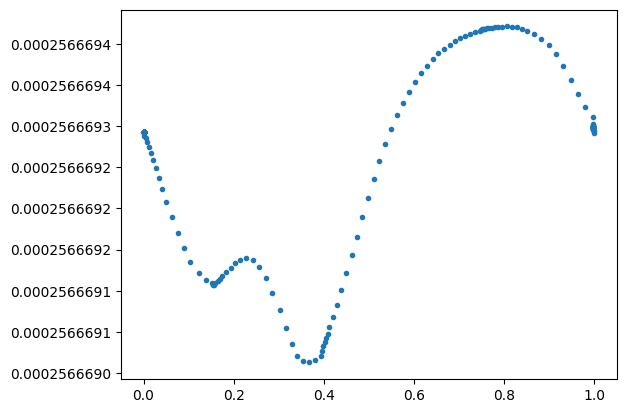

154

In [15]:
# Read the CSV file
# df = pd.read_csv('bvp_ammonia_solution.csv')
# df = pd.read_csv('bvp_ammonia_solution_187.csv')
# df = pd.read_csv('smoothed_solution.csv')

df = pd.read_csv('smoothed_solution_1000hz.csv')


# Extract time and the variables into arrays
times_ivp = df['time'].values
# print(f"Original times_ivp: {times_ivp}")

# Scale to [0, 1]
t_min = np.min(times_ivp)
t_max = np.max(times_ivp)
times_ivp = (times_ivp - t_min) / (t_max - t_min)


# print(f"Scaled times_ivp: {times_ivp}")


solution_N2_T = df['N2_T'].values
solution_N_T = df['N_T'].values
solution_H_T = df['H_T'].values
solution_NH3_T = df['NH3_T'].values
solution_NH2_T = df['NH2_T'].values
solution_NH_T = df['NH_T'].values

solution_N2 = df['N2'].values
solution_H2 = df['H2'].values
solution_NH3 = df['NH3'].values

solution_N2_S = df['N2_S'].values
solution_N_S = df['N_S'].values
solution_H_S = df['H_S'].values
solution_NH3_S = df['NH3_S'].values
solution_NH2_S = df['NH2_S'].values
solution_NH_S = df['NH_S'].values
solution_N_S3 = df['N_S3'].values

# plt.plot(times_ivp, solution_N2, '.')
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.10f'))  # Adjust the number of decimals as needed

# plt.show()

# # print(solution_N2[100], solution_H2[100], solution_NH3[100])

# len(times_ivp)

# # for value in solution_H2:
# #     print(f'{value:.10e}')

In [16]:
def calculate_scaling_factor(array):
    return 1 / np.max(abs(array)) 
    # return 1 / np.mean(array)

array_of_arrays_solutions = [solution_N2_T, solution_N_T, solution_H_T, solution_NH3_T, solution_NH2_T, solution_NH_T, solution_N2,solution_H2, solution_NH3, solution_N2_S, solution_N_S,
                             solution_H_S, solution_NH3_S, solution_NH2_S, solution_NH_S, solution_N_S3]

# scaling_factor = []
# for array in array_of_arrays_solutions:
#     sf = calculate_scaling_factor(array)
#     scaling_factor.append(sf)

# np.shape(scaling_factor)

# scaling_factor
len(solution_H2)

154

In [17]:
# Function to calculate min-max scaling factors
def calculate_minmax_scaling_factors(array):
    min_val = np.min(array)
    max_val = np.max(array)
    range_val = max_val - min_val
    return min_val, range_val

# List of arrays to scale
array_of_arrays_solutions = [solution_N2_T, solution_N_T, solution_H_T, solution_NH3_T,
                             solution_NH2_T, solution_NH_T, solution_N2, solution_H2,
                             solution_NH3, solution_N2_S, solution_N_S, solution_H_S,
                             solution_NH3_S, solution_NH2_S, solution_NH_S, solution_N_S3]

# Calculate min-max scaling factors for each array
scaling_factors = []  # To store (min, range) for each array
for array in array_of_arrays_solutions:
    min_val, range_val = calculate_minmax_scaling_factors(array)
    scaling_factors.append((min_val, range_val))

# Perform the scaling for each array
scaled_arrays = []  # To store scaled arrays
for array, (min_val, range_val) in zip(array_of_arrays_solutions, scaling_factors):
    scaled_array = (array - min_val) / range_val
    scaled_arrays.append(scaled_array)

# # Check results
# for i, scaled_array in enumerate(scaled_arrays):
#     print(f"Array {i}: Min = {np.min(scaled_array):.4f}, Max = {np.max(scaled_array):.4f}")

# # Display the scaling factors
# for i, (min_val, range_val) in enumerate(scaling_factors):
#     print(f"Variable {i}: Min = {min_val:.4f}, Range = {range_val:.4f}")


Array 0: Min = 0.0000, Max = 1.0000
Array 1: Min = 0.0000, Max = 1.0000
Array 2: Min = 0.0000, Max = 1.0000
Array 3: Min = 0.0000, Max = 1.0000
Array 4: Min = 0.0000, Max = 1.0000
Array 5: Min = 0.0000, Max = 1.0000
Array 6: Min = 0.0000, Max = 1.0000
Array 7: Min = 0.0000, Max = 1.0000
Array 8: Min = 0.0000, Max = 1.0000
Array 9: Min = 0.0000, Max = 1.0000
Array 10: Min = 0.0000, Max = 1.0000
Array 11: Min = 0.0000, Max = 1.0000
Array 12: Min = 0.0000, Max = 1.0000
Array 13: Min = 0.0000, Max = 1.0000
Array 14: Min = 0.0000, Max = 1.0000
Array 15: Min = 0.0000, Max = 1.0000
Variable 0: Min = 0.0000, Range = 0.0000
Variable 1: Min = 0.0000, Range = 0.0000
Variable 2: Min = 0.0000, Range = 0.0000
Variable 3: Min = 0.0000, Range = 0.0000
Variable 4: Min = 0.0000, Range = 0.0000
Variable 5: Min = 0.0000, Range = 0.0000
Variable 6: Min = 0.0003, Range = 0.0000
Variable 7: Min = 0.0008, Range = 0.0000
Variable 8: Min = 0.0000, Range = 0.0000
Variable 9: Min = 0.0000, Range = 0.0000
Variable

In [18]:
# scaling_factor = np.ones(16) 


In [19]:
# Function to calculate min-max scaling factors
def calculate_minmax_scaling_factors(array):
    min_val = np.min(array)
    max_val = np.max(array)
    range_val = max_val - min_val
    return min_val, range_val

# Calculate min-max scaling factors for each variable
scaling_factors = []  # To store (min, range) for each variable
for array in array_of_arrays_solutions:
    min_val, range_val = calculate_minmax_scaling_factors(array)
    scaling_factors.append((min_val, range_val))

# # Create a version of scaling_factors filled with ones
scaling_factors = [(0, 1) for _ in scaling_factors]


# Create a scaled version of the data_dict using min-max scaling
data_dict = {
    'time': times_ivp,  # Time remains unchanged
    'N2_T': (solution_N2_T - scaling_factors[0][0]) / scaling_factors[0][1],
    'N_T': (solution_N_T - scaling_factors[1][0]) / scaling_factors[1][1],
    'H_T': (solution_H_T - scaling_factors[2][0]) / scaling_factors[2][1],
    'NH3_T': (solution_NH3_T - scaling_factors[3][0]) / scaling_factors[3][1],
    'NH2_T': (solution_NH2_T - scaling_factors[4][0]) / scaling_factors[4][1],
    'NH_T': (solution_NH_T - scaling_factors[5][0]) / scaling_factors[5][1],
    'N2': (solution_N2 - scaling_factors[6][0]) / scaling_factors[6][1],
    'H2': (solution_H2 - scaling_factors[7][0]) / scaling_factors[7][1],
    'NH3': (solution_NH3 - scaling_factors[8][0]) / scaling_factors[8][1],
    'N2_S': (solution_N2_S - scaling_factors[9][0]) / scaling_factors[9][1],
    'N_S': (solution_N_S - scaling_factors[10][0]) / scaling_factors[10][1],
    'H_S': (solution_H_S - scaling_factors[11][0]) / scaling_factors[11][1],
    'NH3_S': (solution_NH3_S - scaling_factors[12][0]) / scaling_factors[12][1],
    'NH2_S': (solution_NH2_S - scaling_factors[13][0]) / scaling_factors[13][1],
    'NH_S': (solution_NH_S - scaling_factors[14][0]) / scaling_factors[14][1],
    'N_S3': (solution_N_S3 - scaling_factors[15][0]) / scaling_factors[15][1],
}

# # Verify that scaling was applied correctly
# for key, values in data_dict.items():
#     if key != 'time':  # Skip time since it's not scaled
#         print(f"{key}: Min = {np.min(values):.4f}, Max = {np.max(values):.4f}")

scaling_factors


[(0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1)]

In [21]:
solution_python= []

for i, array in enumerate(array_of_arrays_solutions):
    # print(f'array {i}, last point : {array[-1]}')
    solution_python.append(np.mean(array[-1000:-1]))

solution_python

[1.9247500624917016e-10,
 1.597572665301341e-07,
 9.51493053218236e-08,
 1.1853273450876101e-11,
 1.2387142495756235e-10,
 2.8225448989972357e-06,
 0.0002566692618091955,
 0.0007700062333281915,
 3.0268540039277607e-07,
 4.936299497746778e-12,
 1.9599631178959228e-09,
 2.1741237794293407e-09,
 1.3202043902817903e-11,
 5.72902882257415e-08,
 1.4003646512257238e-09,
 7.689525817351693e-13]

## Creating the pyomo model to be solved

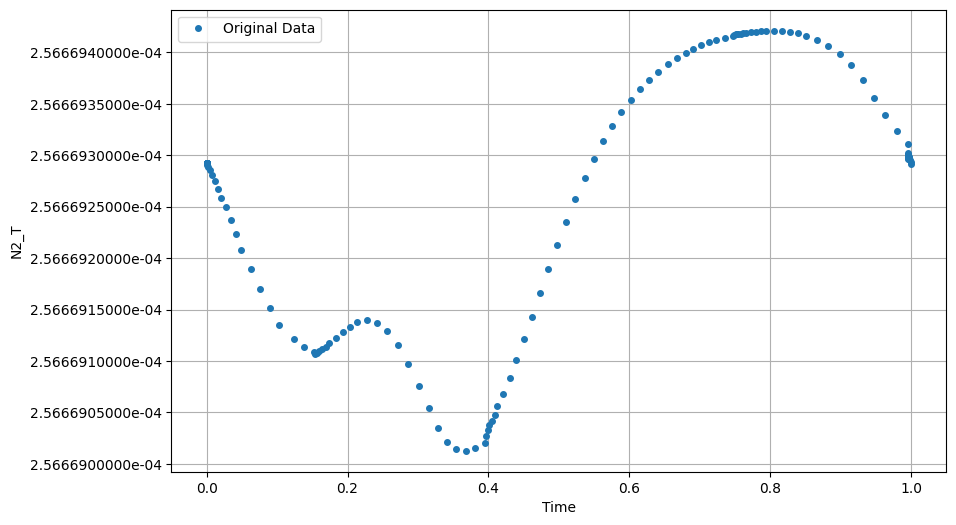

0.00025666913846306556

In [22]:
# Define the new time points for interpolation
new_time_points = np.linspace(times_ivp.min(), times_ivp.max(), 1000)  # 1000 points

# Interpolate the solution
interpolator = interp1d(times_ivp, solution_N2, kind='linear')
# interpolator =Akima1DInterpolator(times_ivp, solution_N2 * scaling_factor[6])
interpolated_solution = interpolator(new_time_points)

# Plot the original solution and the interpolated result
plt.figure(figsize=(10, 6))
plt.plot(times_ivp, (solution_N2 - scaling_factors[6][0]) / scaling_factors[6][1], 'o', label='Original Data', markersize=4)
# plt.plot(new_time_points, interpolated_solution, '-', label='Interpolated (Cubic)')
plt.xlabel('Time')
plt.ylabel('N2_T')
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.10e'))  # Adjust the number of decimals as needed

plt.show()

interpolated_solution[100]


In [23]:
max_values = [np.max(solution) for solution in array_of_arrays_solutions]
# max_values

In [24]:
# maxscaling = [(max_value * scaling) for max_value, scaling in zip(max_values, scaling_factor)]
# maxscaling

In [25]:
mean_solutions = [np.mean(solution) for solution in array_of_arrays_solutions]
# mean_solutions

In [26]:
# meanscaling = [(mean * scaling) for mean, scaling in zip(mean_solutions, scaling_factor)]
# meanscaling

## Creating the pyomo model to be solved

In [27]:
def create_pyomo_model(params):
    """
    Creates the pyomo model for the CSTR. Uses Backwards Finite Difference method to discretize the time span and 
    a system of equations from the ODE system modelled here. 
    
    Args:
        params: From where to take the parameter values. For now we only have one option, the class "Params"

    Returns:
        Discretized Pyomo model
    """
    
    abyv = params.abyv
    Q_in = params.Q_in
    Q_out = params.Q_out
    V = params.V
    T = params.T
    nfe = params.nfe
    beta = params.beta
    R_e = params.R_e
    T_ref = params.T_ref
    MWON = params.MWON
    Stick = params.Stick
    T_gas = params.T_gas
    Effects = params.Effects
    Stoic = params.Stoic
    mb = params.mb
    b = params.b
    SDTOT  = params.SDTOT 
    R_k = params.R_k
    
    ic = initial_calculations(params)

    # Create Pyomo model and parameters
    m = ConcreteModel()
    m.params = params
    
    # # Create time span
    # m.times = ContinuousSet(bounds=(0, 30)) 


    # Create time span
    # Scaling time to be between 0 and 1 
    m.times = ContinuousSet(bounds=(0, 1)) 
    # True time span, dependent of tau
    m.tau = Var(m.times) 


    
    # # Parameter fir the final time to be equal the number of periods times the wave period 
    m.tf = Param(initialize = 1 / freq_osci)



    interp_function_N2_T = Akima1DInterpolator(
        times_ivp, (solution_N2_T - scaling_factors[0][0]) / scaling_factors[0][1]
    )
    interp_function_N_T = Akima1DInterpolator(
        times_ivp, (solution_N_T - scaling_factors[1][0]) / scaling_factors[1][1]
    )
    interp_function_H_T = Akima1DInterpolator(
        times_ivp, (solution_H_T - scaling_factors[2][0]) / scaling_factors[2][1]
    )
    interp_function_NH3_T = Akima1DInterpolator(
        times_ivp, (solution_NH3_T - scaling_factors[3][0]) / scaling_factors[3][1]
    )
    interp_function_NH2_T = Akima1DInterpolator(
        times_ivp, (solution_NH2_T - scaling_factors[4][0]) / scaling_factors[4][1]
    )
    interp_function_NH_T = Akima1DInterpolator(
        times_ivp, (solution_NH_T - scaling_factors[5][0]) / scaling_factors[5][1]
    )

    interp_function_N2 = Akima1DInterpolator(
        times_ivp, (solution_N2 - scaling_factors[6][0]) / scaling_factors[6][1]
    )
    interp_function_H2 = Akima1DInterpolator(
        times_ivp, (solution_H2 - scaling_factors[7][0]) / scaling_factors[7][1]
    )
    interp_function_NH3 = Akima1DInterpolator(
        times_ivp, (solution_NH3 - scaling_factors[8][0]) / scaling_factors[8][1]
    )

    interp_function_N2_S = Akima1DInterpolator(
        times_ivp, (solution_N2_S - scaling_factors[9][0]) / scaling_factors[9][1]
    )
    interp_function_N_S = Akima1DInterpolator(
        times_ivp, (solution_N_S - scaling_factors[10][0]) / scaling_factors[10][1]
    )
    interp_function_H_S = Akima1DInterpolator(
        times_ivp, (solution_H_S - scaling_factors[11][0]) / scaling_factors[11][1]
    )
    interp_function_NH3_S = Akima1DInterpolator(
        times_ivp, (solution_NH3_S - scaling_factors[12][0]) / scaling_factors[12][1]
    )
    interp_function_NH2_S = Akima1DInterpolator(
        times_ivp, (solution_NH2_S - scaling_factors[13][0]) / scaling_factors[13][1]
    )
    interp_function_NH_S = Akima1DInterpolator(
        times_ivp, (solution_NH_S - scaling_factors[14][0]) / scaling_factors[14][1]
    )
    interp_function_N_S3 = Akima1DInterpolator(
        times_ivp, (solution_N_S3 - scaling_factors[15][0]) / scaling_factors[15][1]
    )


    # Define callable functions for initialization
    def N2_T_init_func(m, t):
        return float(interp_function_N2_T(t))

    def N_T_init_func(m, t):
        return float(interp_function_N_T(t))

    def H_T_init_func(m, t):
        return float(interp_function_H_T(t))

    def NH3_T_init_func(m, t):
        return float(interp_function_NH3_T(t))

    def NH2_T_init_func(m, t):
        return float(interp_function_NH2_T(t))

    def NH_T_init_func(m, t):
        return float(interp_function_NH_T(t))

    def N2_init_func(m, t):
        return float(interp_function_N2(t))

    def H2_init_func(m, t):
        return float(interp_function_H2(t))

    def NH3_init_func(m, t):
        return float(interp_function_NH3(t))

    def N2_S_init_func(m, t):
        return float(interp_function_N2_S(t))

    def N_S_init_func(m, t):
        return float(interp_function_N_S(t))

    def H_S_init_func(m, t):
        return float(interp_function_H_S(t))

    def NH3_S_init_func(m, t):
        return float(interp_function_NH3_S(t))

    def NH2_S_init_func(m, t):
        return float(interp_function_NH2_S(t))

    def NH_S_init_func(m, t):
        return float(interp_function_NH_S(t))

    def N_S3_init_func(m, t):
        return float(interp_function_N_S3(t))


    # Define variables with callable initialization
    m.N2_T = Var(m.times, initialize=N2_T_init_func)
    m.N_T = Var(m.times, initialize=N_T_init_func)
    m.H_T = Var(m.times, initialize=H_T_init_func)
    m.NH3_T = Var(m.times, initialize=NH3_T_init_func)
    m.NH2_T = Var(m.times, initialize=NH2_T_init_func)
    m.NH_T = Var(m.times, initialize=NH_T_init_func)

    m.N2 = Var(m.times, initialize=N2_init_func)
    m.H2 = Var(m.times, initialize=H2_init_func)
    m.NH3 = Var(m.times, initialize=NH3_init_func)

    m.N2_S = Var(m.times, initialize=N2_S_init_func)
    m.N_S = Var(m.times, initialize=N_S_init_func)
    m.H_S = Var(m.times, initialize=H_S_init_func)
    m.NH3_S = Var(m.times, initialize=NH3_S_init_func)
    m.NH2_S = Var(m.times, initialize=NH2_S_init_func)
    m.NH_S = Var(m.times, initialize=NH_S_init_func)
    m.N_S3 = Var(m.times, initialize=N_S3_init_func)


    # m.N2_T = Var(m.times, initialize=(mean_solutions[0] - scaling_factors[0][0]) / scaling_factors[0][1], within=Reals)
    # m.N_T = Var(m.times, initialize=(mean_solutions[1] - scaling_factors[1][0]) / scaling_factors[1][1], within=Reals)
    # m.H_T = Var(m.times, initialize=(mean_solutions[2] - scaling_factors[2][0]) / scaling_factors[2][1], within=Reals)
    # m.NH3_T = Var(m.times, initialize=(mean_solutions[3] - scaling_factors[3][0]) / scaling_factors[3][1], within=Reals)
    # m.NH2_T = Var(m.times, initialize=(mean_solutions[4] - scaling_factors[4][0]) / scaling_factors[4][1], within=Reals)
    # m.NH_T = Var(m.times, initialize=(mean_solutions[5] - scaling_factors[5][0]) / scaling_factors[5][1], within=Reals)

    # m.N2 = Var(m.times, initialize=(solution_N2[0] - scaling_factors[6][0]) / scaling_factors[6][1], within=Reals)
    # m.H2 = Var(m.times, initialize=(solution_H2[0] - scaling_factors[7][0]) / scaling_factors[7][1], within=Reals)
    # m.NH3 = Var(m.times, initialize=(mean_solutions[8] - scaling_factors[8][0]) / scaling_factors[8][1], within=Reals)

    # m.N2_S = Var(m.times, initialize=(mean_solutions[9] - scaling_factors[9][0]) / scaling_factors[9][1], within=Reals)
    # m.N_S = Var(m.times, initialize=(mean_solutions[10] - scaling_factors[10][0]) / scaling_factors[10][1], within=Reals)
    # m.H_S = Var(m.times, initialize=(mean_solutions[11] - scaling_factors[11][0]) / scaling_factors[11][1], within=Reals)
    # m.NH3_S = Var(m.times, initialize=(mean_solutions[12] - scaling_factors[12][0]) / scaling_factors[12][1], within=Reals)
    # m.NH2_S = Var(m.times, initialize=(mean_solutions[13] - scaling_factors[13][0]) / scaling_factors[13][1], within=Reals)
    # m.NH_S = Var(m.times, initialize=(mean_solutions[14] - scaling_factors[14][0]) / scaling_factors[14][1], within=Reals)
    # m.N_S3 = Var(m.times, initialize=(mean_solutions[15] - scaling_factors[15][0]) / scaling_factors[15][1], within=Reals)

    
    # m.N2_T = Var(m.times) # 0
    # m.N_T = Var(m.times)  # 1
    # m.H_T = Var(m.times) # 2
    # m.NH3_T = Var(m.times ) # 3
    # m.NH2_T = Var(m.times) # 4
    # m.NH_T = Var(m.times) # 5

    # m.N2 = Var(m.times) # 6
    # m.H2 = Var(m.times) # 7
    # m.NH3 = Var(m.times) # 8

    # m.N2_S = Var(m.times) # 9
    # m.N_S = Var(m.times) # 10
    # m.H_S = Var(m.times) # 11
    # m.NH3_S = Var(m.times) # 12
    # m.NH2_S = Var(m.times) # 13
    # m.NH_S = Var(m.times) # 14
    # m.N_S3 = Var(m.times) # 15



    # Derivative variables are equivalent to the ds array
    m.dtimedtimes= DerivativeVar(m.tau) # For time scaling
    m.dN2_Tdt = DerivativeVar(m.N2_T) # 0
    m.dN_Tdt = DerivativeVar(m.N_T) # 1
    m.dH_Tdt = DerivativeVar(m.H_T) # 2
    m.dNH3_Tdt = DerivativeVar(m.NH3_T) # 3
    m.dNH2_Tdt = DerivativeVar(m.NH2_T) # 4
    m.dNH_Tdt = DerivativeVar(m.NH_T) # 5
    
    m.dN2dt = DerivativeVar(m.N2) # 6
    m.dH2dt = DerivativeVar(m.H2) # 7
    m.dNH3dt = DerivativeVar(m.NH3) # 8
    
    m.dN2_Sdt = DerivativeVar(m.N2_S) # 9
    m.dN_Sdt = DerivativeVar(m.N_S) # 10
    m.dH_Sdt = DerivativeVar(m.H_S) # 11
    m.dNH3_Sdt = DerivativeVar(m.NH3_S) # 12
    m.dNH2_Sdt = DerivativeVar(m.NH2_S) # 13
    m.dNH_Sdt = DerivativeVar(m.NH_S) # 14
    m.dN_S3dt = DerivativeVar(m.N_S3) # 15


    # Constraint that says dtime/dtau = final time, since time = tau * final time
    @m.Constraint(m.times)
    def _ode3(m,t):
        if t ==  0:
            return Constraint.Skip
        return m.dtimedtimes[t] == m.tf 



    @m.Expression(m.times)
    def vac_T_expr(m, t):
        N2_T_unscaled = m.N2_T[t] * scaling_factors[0][1] + scaling_factors[0][0]
        N_T_unscaled = m.N_T[t] * scaling_factors[1][1] + scaling_factors[1][0]
        H_T_unscaled = m.H_T[t] * scaling_factors[2][1] + scaling_factors[2][0]
        NH3_T_unscaled = m.NH3_T[t] * scaling_factors[3][1] + scaling_factors[3][0]
        NH2_T_unscaled = m.NH2_T[t] * scaling_factors[4][1] + scaling_factors[4][0]
        NH_T_unscaled = m.NH_T[t] * scaling_factors[5][1] + scaling_factors[5][0]

        ic = initial_calculations(m.params)
        return ic.SDEN_T * abyv - (N2_T_unscaled + N_T_unscaled + H_T_unscaled + NH3_T_unscaled + NH2_T_unscaled + NH_T_unscaled)

    @m.Expression(m.times)
    def vac_S_expr(m, t):
        N2_S_unscaled = m.N2_S[t] * scaling_factors[9][1] + scaling_factors[9][0]
        N_S_unscaled = m.N_S[t] * scaling_factors[10][1] + scaling_factors[10][0]
        H_S_unscaled = m.H_S[t] * scaling_factors[11][1] + scaling_factors[11][0]
        NH3_S_unscaled = m.NH3_S[t] * scaling_factors[12][1] + scaling_factors[12][0]
        NH2_S_unscaled = m.NH2_S[t] * scaling_factors[13][1] + scaling_factors[13][0]
        NH_S_unscaled = m.NH_S[t] * scaling_factors[14][1] + scaling_factors[14][0]
        N_S3_unscaled = m.N_S3[t] * scaling_factors[15][1] + scaling_factors[15][0]

        ic = initial_calculations(m.params)
        return ic.SDEN_S * abyv - (N2_S_unscaled + N_S_unscaled + H_S_unscaled + NH3_S_unscaled + NH2_S_unscaled + NH_S_unscaled + N_S3_unscaled)
    
    
    # Declare ODEs as contraints
    # 0
    @m.Constraint(m.times)
    def dN2_Tdt_eq(m, t):
        N2_T_unscaled = m.N2_T[t] * scaling_factors[0][1] + scaling_factors[0][0]
        N_T_unscaled = m.N_T[t] * scaling_factors[1][1] + scaling_factors[1][0]
        N2_unscaled = m.N2[t] * scaling_factors[6][1] + scaling_factors[6][0]

        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]

        kf, kb, _ = amm_kinetics4(m.params, t)
      

        return m.dN2_Tdt[t] == m.tf *  (kf[0] * N2_unscaled * vac_T - kb[0] * N2_T_unscaled + kb[1] * N_T_unscaled**2 - kf[1] * N2_T_unscaled * vac_T) / scaling_factors[0][1]
    
    
        
    # 1
    @m.Constraint(m.times)
    def dN_Tdt_eq(m, t):
        N2_T_unscaled = m.N2_T[t] * scaling_factors[0][1] + scaling_factors[0][0]
        N_T_unscaled = m.N_T[t] * scaling_factors[1][1] + scaling_factors[1][0]
        H_T_unscaled = m.H_T[t] * scaling_factors[2][1] + scaling_factors[2][0]
        NH_T_unscaled = m.NH_T[t] * scaling_factors[5][1] + scaling_factors[5][0]
        N2_S_unscaled = m.N2_S[t] * scaling_factors[9][1] + scaling_factors[9][0]
        N_S_unscaled = m.N_S[t] * scaling_factors[10][1] + scaling_factors[10][0]
        N_S3_unscaled = m.N_S3[t] * scaling_factors[15][1] + scaling_factors[15][0]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]

        kf, kb, _ = amm_kinetics4(m.params, t)
      

        return m.dN_Tdt[t]  == m.tf * (2 * kf[1] * N2_T_unscaled * vac_T - 2 * kb[1] * N_T_unscaled**2 + kf[5] * NH_T_unscaled * vac_T 
                            - kb[5] * N_T_unscaled * H_T_unscaled + kb[14] * N_S_unscaled * vac_T - kf[14] * N_T_unscaled * vac_S 
                            + kf[19] * N2_S_unscaled * vac_T - kb[19] * N_T_unscaled * N_S_unscaled + kb[21] * N_S3_unscaled * vac_T 
                            - kf[21] * N_T_unscaled * vac_S) / scaling_factors[1][1]

    
    
    # 2  
    @m.Constraint(m.times)
    def dH_Tdt_eq(m, t):
        N_T_unscaled = m.N_T[t] * scaling_factors[1][1] + scaling_factors[1][0]
        H_T_unscaled = m.H_T[t] * scaling_factors[2][1] + scaling_factors[2][0]
        NH3_T_unscaled = m.NH3_T[t] * scaling_factors[3][1] + scaling_factors[3][0]
        NH2_T_unscaled = m.NH2_T[t] * scaling_factors[4][1] + scaling_factors[4][0]
        NH_T_unscaled = m.NH_T[t] * scaling_factors[5][1] + scaling_factors[5][0]
        H2_unscaled = m.H2[t] * scaling_factors[7][1] + scaling_factors[7][0]
        H_S_unscaled = m.H_S[t] * scaling_factors[11][1] + scaling_factors[11][0]

    
        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]

        kf, kb, _ = amm_kinetics4(m.params, t)
      
        # Return the ODE using unscaled variables
        return m.dH_Tdt[t]  == m.tf * (2 * kf[2] * H2_unscaled * vac_T**2 - 2 * kb[2] * H_T_unscaled**2 + kf[3] * NH3_T_unscaled * vac_T 
                            - kb[3] * NH2_T_unscaled * H_T_unscaled + kf[4] * NH2_T_unscaled * vac_T 
                            - kb[4] * NH_T_unscaled * H_T_unscaled + kf[5] * NH_T_unscaled * vac_T 
                            - kb[5] * N_T_unscaled * H_T_unscaled + kb[15] * H_S_unscaled * vac_T - kf[15] * H_T_unscaled * vac_S)  / scaling_factors[2][1]


    # 3
    @m.Constraint(m.times)
    def dNH3_Tdt_eq(m, t):
        H_T_unscaled = m.H_T[t] * scaling_factors[2][1] + scaling_factors[2][0]
        NH3_T_unscaled = m.NH3_T[t] * scaling_factors[3][1] + scaling_factors[3][0]
        NH2_T_unscaled = m.NH2_T[t] * scaling_factors[4][1] + scaling_factors[4][0]
        NH3_unscaled = m.NH3[t] * scaling_factors[8][1] + scaling_factors[8][0]
        NH3_S_unscaled = m.NH3_S[t] * scaling_factors[12][1] + scaling_factors[12][0]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]

        kf, kb, _ = amm_kinetics4(m.params, t)
      
        return m.dNH3_Tdt[t]  == m.tf * (kb[3] * NH2_T_unscaled * H_T_unscaled - kf[3] * NH3_T_unscaled * vac_T 
                                 + kf[6] * NH3_unscaled * vac_T - kb[6] * NH3_T_unscaled 
                                 + kb[16] * NH3_S_unscaled * vac_T - kf[16] * NH3_T_unscaled * vac_S) / scaling_factors[3][1]


    

    # 4
    @m.Constraint(m.times)
    def dNH2_Tdt_eq(m, t):
        H_T_unscaled = m.H_T[t] * scaling_factors[2][1] + scaling_factors[2][0]
        NH3_T_unscaled = m.NH3_T[t] * scaling_factors[3][1] + scaling_factors[3][0]
        NH2_T_unscaled = m.NH2_T[t] * scaling_factors[4][1] + scaling_factors[4][0]
        NH_T_unscaled = m.NH_T[t] * scaling_factors[5][1] + scaling_factors[5][0]
        NH2_S_unscaled = m.NH2_S[t] * scaling_factors[13][1] + scaling_factors[13][0]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]

        kf, kb, _ = amm_kinetics4(m.params, t)
      

        return m.dNH2_Tdt[t] == m.tf * (kf[3] * NH3_T_unscaled * vac_T - kb[3] * NH2_T_unscaled * H_T_unscaled 
                                 + kb[4] * NH_T_unscaled * H_T_unscaled - kf[4] * NH2_T_unscaled * vac_T 
                                 + kb[17] * NH2_S_unscaled * vac_T - kf[17] * NH2_T_unscaled * vac_S) / scaling_factors[4][1]

    
    # 5
    @m.Constraint(m.times)
    def dNH_Tdt_eq(m, t):
        N_T_unscaled = m.N_T[t] * scaling_factors[1][1] + scaling_factors[1][0]
        H_T_unscaled = m.H_T[t] * scaling_factors[2][1] + scaling_factors[2][0]
        NH2_T_unscaled = m.NH2_T[t] * scaling_factors[4][1] + scaling_factors[4][0]
        NH_T_unscaled = m.NH_T[t] * scaling_factors[5][1] + scaling_factors[5][0]
        NH_S_unscaled = m.NH_S[t] * scaling_factors[14][1] + scaling_factors[14][0]



        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]

        kf, kb, _ = amm_kinetics4(m.params, t)
      

        return m.dNH_Tdt[t]  == m.tf * (kf[4] * NH2_T_unscaled * vac_T - kb[4] * NH_T_unscaled * H_T_unscaled 
                                + kb[5] * N_T_unscaled * H_T_unscaled - kf[5] * NH_T_unscaled * vac_T 
                                + kb[18] * NH_S_unscaled * vac_T - kf[18] * NH_T_unscaled * vac_S) / scaling_factors[5][1]


    # 6
    @m.Constraint(m.times)
    def dN2dt_eq(m, t):
        N2_T_unscaled = m.N2_T[t] * scaling_factors[0][1] + scaling_factors[0][0]
        N2_unscaled = m.N2[t] * scaling_factors[6][1] + scaling_factors[6][0]
        N2_S_unscaled = m.N2_S[t] * scaling_factors[9][1] + scaling_factors[9][0]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]

        kf, kb, _ = amm_kinetics4(m.params, t)
      

        return m.dN2dt[t] ==  m.tf *(kb[0] * N2_T_unscaled - kf[0] * N2_unscaled * vac_T 
                              + kb[7] * N2_S_unscaled - kf[7] * N2_unscaled * vac_S 
                              + Q_in * ic.c_N2 / V - Q_out * N2_unscaled / V) / scaling_factors[6][1]
    
    
    # 7
    @m.Constraint(m.times)
    def dH2dt_eq(m, t):
        H_T_unscaled = m.H_T[t] * scaling_factors[2][1] + scaling_factors[2][0]
        H2_unscaled = m.H2[t] * scaling_factors[7][1] + scaling_factors[7][0]
        H_S_unscaled = m.H_S[t] * scaling_factors[11][1] + scaling_factors[11][0]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]

        kf, kb, _ = amm_kinetics4(m.params, t)
      

        return m.dH2dt[t] == m.tf * (kb[2] * H_T_unscaled**2 - kf[2] * H2_unscaled * vac_T**2 
                              + kb[9] * H_S_unscaled**2 - kf[9] * H2_unscaled * vac_S**2 
                              + Q_in * ic.c_H2 / V - Q_out * H2_unscaled / V)  / scaling_factors[7][1]
    
    
 
   
    # 8
    @m.Constraint(m.times)
    def dNH3dt_eq(m, t):
        NH3_T_unscaled = m.NH3_T[t] * scaling_factors[3][1] + scaling_factors[3][0]
        NH3_unscaled = m.NH3[t] * scaling_factors[8][1] + scaling_factors[8][0]
        NH3_S_unscaled = m.NH3_S[t] * scaling_factors[12][1] + scaling_factors[12][0]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]

        kf, kb, _ = amm_kinetics4(m.params, t)
      

        return m.dNH3dt[t]  == m.tf * (kb[6] * NH3_T_unscaled - kf[6] * NH3_unscaled * vac_T 
                               + kb[13] * NH3_S_unscaled - kf[13] * NH3_unscaled * vac_S 
                               + Q_in * ic.c_NH3 / V - Q_out * NH3_unscaled / V)  / scaling_factors[8][1]


    
    # 9
    @m.Constraint(m.times)
    def dN2_Sdt_eq(m, t):
        N_T_unscaled = m.N_T[t] * scaling_factors[1][1] + scaling_factors[1][0]
        N2_unscaled = m.N2[t] * scaling_factors[6][1] + scaling_factors[6][0]
        N2_S_unscaled = m.N2_S[t] * scaling_factors[9][1] + scaling_factors[9][0]
        N_S_unscaled = m.N_S[t] * scaling_factors[10][1] + scaling_factors[10][0]
        N_S3_unscaled = m.N_S3[t] * scaling_factors[15][1] + scaling_factors[15][0]

        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]

        kf, kb, _ = amm_kinetics4(m.params, t)
      

        return m.dN2_Sdt[t] == m.tf * (kf[7] * N2_unscaled * vac_S - kb[7] * N2_S_unscaled 
                               + kb[8] * N_S_unscaled**2 - kf[8] * N2_S_unscaled * vac_S 
                               + kb[19] * N_T_unscaled * N_S_unscaled - kf[19] * N2_S_unscaled * vac_T 
                               + kb[20] * N_S_unscaled * N_S3_unscaled - kf[20] * N2_S_unscaled * vac_S) / scaling_factors[9][1]
    

    


    # 10
    @m.Constraint(m.times)
    def dN_Sdt_eq(m, t):
        N_T_unscaled = m.N_T[t] * scaling_factors[1][1] + scaling_factors[1][0]
        N2_S_unscaled = m.N2_S[t] * scaling_factors[9][1] + scaling_factors[9][0]
        N_S_unscaled = m.N_S[t] * scaling_factors[10][1] + scaling_factors[10][0]
        H_S_unscaled = m.H_S[t] * scaling_factors[11][1] + scaling_factors[11][0]
        NH_S_unscaled = m.NH_S[t] * scaling_factors[14][1] + scaling_factors[14][0]
        N_S3_unscaled = m.N_S3[t] * scaling_factors[15][1] + scaling_factors[15][0]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]

        kf, kb, _ = amm_kinetics4(m.params, t)
      

        return m.dN_Sdt[t]  == m.tf * (2 * kf[8] * N2_S_unscaled * vac_S - 2 * kb[8] * N_S_unscaled**2 
                               + kf[12] * NH_S_unscaled * vac_S - kb[12] * N_S_unscaled * H_S_unscaled 
                               + kf[14] * N_T_unscaled * vac_S - kb[14] * N_S_unscaled * vac_T 
                               + kf[19] * N2_S_unscaled * vac_T - kb[19] * N_T_unscaled * N_S_unscaled 
                               + kf[20] * N2_S_unscaled * vac_S - kb[20] * N_S_unscaled * N_S3_unscaled) / scaling_factors[10][1]


        

    
    # 11
    @m.Constraint(m.times)
    def dH_Sdt_eq(m, t):
        H_T_unscaled = m.H_T[t] * scaling_factors[2][1] + scaling_factors[2][0]
        H2_unscaled = m.H2[t] * scaling_factors[7][1] + scaling_factors[7][0]
        N_S_unscaled = m.N_S[t] * scaling_factors[10][1] + scaling_factors[10][0]
        H_S_unscaled = m.H_S[t] * scaling_factors[11][1] + scaling_factors[11][0]
        NH3_S_unscaled = m.NH3_S[t] * scaling_factors[12][1] + scaling_factors[12][0]
        NH2_S_unscaled = m.NH2_S[t] * scaling_factors[13][1] + scaling_factors[13][0]
        NH_S_unscaled = m.NH_S[t] * scaling_factors[14][1] + scaling_factors[14][0]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]

        kf, kb, _ = amm_kinetics4(m.params, t)
      

        return m.dH_Sdt[t] == m.tf * (2 * kf[9] * H2_unscaled * vac_S**2 - 2 * kb[9] * H_S_unscaled**2 
                               + kf[10] * NH3_S_unscaled * vac_S - kb[10] * NH2_S_unscaled * H_S_unscaled 
                               + kf[11] * NH2_S_unscaled * vac_S - kb[11] * NH_S_unscaled * H_S_unscaled 
                               + kf[12] * NH_S_unscaled * vac_S - kb[12] * N_S_unscaled * H_S_unscaled 
                               + kf[15] * H_T_unscaled * vac_S - kb[15] * H_S_unscaled * vac_T) / scaling_factors[11][1]
    


    
    # 12
    @m.Constraint(m.times)
    def dNH3_Sdt_eq(m, t):
        NH3_T_unscaled = m.NH3_T[t] * scaling_factors[3][1] + scaling_factors[3][0]
        NH3_unscaled = m.NH3[t] * scaling_factors[8][1] + scaling_factors[8][0]
        H_S_unscaled = m.H_S[t] * scaling_factors[11][1] + scaling_factors[11][0]
        NH3_S_unscaled = m.NH3_S[t] * scaling_factors[12][1] + scaling_factors[12][0]
        NH2_S_unscaled = m.NH2_S[t] * scaling_factors[13][1] + scaling_factors[13][0]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]

        kf, kb, _ = amm_kinetics4(m.params, t)
      

        return m.dNH3_Sdt[t] == m.tf * (kb[10] * NH2_S_unscaled * H_S_unscaled - kf[10] * NH3_S_unscaled * vac_S 
                                 + kf[13] * NH3_unscaled * vac_S - kb[13] * NH3_S_unscaled 
                                 + kf[16] * NH3_T_unscaled * vac_S - kb[16] * NH3_S_unscaled * vac_T) / scaling_factors[12][1]
    


    
    # 13
    @m.Constraint(m.times)
    def dNH2_Sdt_eq(m, t):
        NH2_T_unscaled = m.NH2_T[t] * scaling_factors[4][1] + scaling_factors[4][0]
        H_S_unscaled = m.H_S[t] * scaling_factors[11][1] + scaling_factors[11][0]
        NH3_S_unscaled = m.NH3_S[t] * scaling_factors[12][1] + scaling_factors[12][0]
        NH2_S_unscaled = m.NH2_S[t] * scaling_factors[13][1] + scaling_factors[13][0]
        NH_S_unscaled = m.NH_S[t] * scaling_factors[14][1] + scaling_factors[14][0]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]

        kf, kb, _ = amm_kinetics4(m.params, t)
      

        return m.dNH2_Sdt[t]  == m.tf * (kf[10] * NH3_S_unscaled * vac_S - kb[10] * NH2_S_unscaled * H_S_unscaled 
                                 + kb[11] * NH_S_unscaled * H_S_unscaled - kf[11] * NH2_S_unscaled * vac_S 
                                 + kf[17] * NH2_T_unscaled * vac_S - kb[17] * NH2_S_unscaled * vac_T) / scaling_factors[13][1]
    
    
    # 14
    @m.Constraint(m.times)
    def dNH_Sdt_eq(m, t):
        NH_T_unscaled = m.NH_T[t] * scaling_factors[5][1] + scaling_factors[5][0]
        N_S_unscaled = m.N_S[t] * scaling_factors[10][1] + scaling_factors[10][0]
        H_S_unscaled = m.H_S[t] * scaling_factors[11][1] + scaling_factors[11][0]
        NH2_S_unscaled = m.NH2_S[t] * scaling_factors[13][1] + scaling_factors[13][0]
        NH_S_unscaled = m.NH_S[t] * scaling_factors[14][1] + scaling_factors[14][0]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]

        kf, kb, _ = amm_kinetics4(m.params, t)
      

        return m.dNH_Sdt[t] == m.tf * (kf[11] * NH2_S_unscaled * vac_S - kb[11] * NH_S_unscaled * H_S_unscaled 
                               + kb[12] * N_S_unscaled * H_S_unscaled - kf[12] * NH_S_unscaled * vac_S 
                               + kf[18] * NH_T_unscaled * vac_S - kb[18] * NH_S_unscaled * vac_T)  / scaling_factors[14][1]

    

    # 15 
    @m.Constraint(m.times)
    def dN_S3dt_eq(m, t):
        N_T_unscaled = m.N_T[t] * scaling_factors[1][1] + scaling_factors[1][0]
        N2_S_unscaled = m.N2_S[t] * scaling_factors[9][1] + scaling_factors[9][0]
        N_S_unscaled = m.N_S[t] * scaling_factors[10][1] + scaling_factors[10][0]
        N_S3_unscaled = m.N_S3[t] * scaling_factors[15][1] + scaling_factors[15][0]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]

        kf, kb, _ = amm_kinetics4(m.params, t)
      

        return m.dN_S3dt[t] * scaling_factors[15][1] == m.tf * (kf[20] * N2_S_unscaled * vac_S - kb[20] * N_S_unscaled * N_S3_unscaled 
                                + kf[21] * N_T_unscaled * vac_S - kb[21] * N_S3_unscaled * vac_T)  
    

    print(f"Discretizing...")
    

    # # Declare discretization method and parameters 
    discretizer = TransformationFactory('dae.finite_difference')
    discretizer.apply_to(m, nfe = 500, scheme='BACKWARD')
    

    # discretizer = TransformationFactory('dae.collocation')
    # discretizer.apply_to(m, nfe=50, ncp=3, scheme='LAGRANGE-RADAU')  

    print(f"Discretized in {len(m.times)} points")

    # List of state variables
    state_variables = ['N2_T', 'N_T', 'H_T', 'NH3_T', 'NH2_T', 'NH_T', 
                    'N2', 'H2', 'NH3', 'N2_S', 'N_S', 'H_S', 'NH3_S', 
                    'NH2_S', 'NH_S', 'N_S3']

    # Pyomo time points
    pyomo_time = [t for t in m.times]

    # Automate plotting for all variables
    for var_name in state_variables:
        # Pyomo solution (unscaled)
        pyomo_var = [
            value(getattr(m, var_name)[t]) for t in m.times
        ]
        
        # SciPy solution (unscaled, already directly from `data_dict`)
        scipy_var = data_dict[var_name]  # No scaling applied
        
        # Plot both solutions
        plt.figure(figsize=(10, 6))
        plt.plot(data_dict['time'], scipy_var, 'ro-', label=f'{var_name} (SciPy)')
        plt.plot(pyomo_time, pyomo_var, 'b.', label=f'{var_name} (Pyomo)')
        plt.xlabel('Time')
        plt.ylabel(var_name)
        plt.title(f'Comparison of SciPy and Pyomo Solutions for {var_name} (Unscaled)')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Return the model
    return m

In [28]:
def tof_from_decision_vars(params, tee=True):
    """
    Solves the Pyomo model and calculates avTOF from results of solving the BVP
    
    Args:
        params: From where to take the parameter values. For now we only have one option, the class "Params"
        tee = True: Returns the ipopt log, which is advised. Use Tee = False in case you do not want to see the log.

    Returns:
        Values of turnover frequency in each point in time and value of the time-averaged turnover frequency
    """
    
    Q_in = params.Q_in
    SDTOT = params.SDTOT
    abyv = params.abyv
    V = params.V
    Q_out = params.Q_out
        
    # Get the Pyomo model
    m = create_pyomo_model(params)
    
    # Key part of the simultaneous approach
    # Equality constraints for initial and final points - to enforce periodicity 
    # and direct simulation of cyclic steady state
    # m.N2_TCSS = Constraint(expr = m.N2_T[m.times.first()] == m.N2_T[m.times.last()]) # 0
    # m.N_TCSS = Constraint(expr = m.N_T[m.times.first()] == m.N_T[m.times.last()]) # 1
    # m.H_TCSS = Constraint(expr = m.H_T[m.times.first()] == m.H_T[m.times.last()]) # 2
    # m.NH3_TCSS = Constraint(expr = m.NH3_T[m.times.first()] == m.NH3_T[m.times.last()]) # 3
    # m.NH2_TCSS = Constraint(expr = m.NH2_T[m.times.first()] == m.NH2_T[m.times.last()]) # 4
    # m.NH_TCSS = Constraint(expr = m.NH_T[m.times.first()] == m.NH_T[m.times.last()]) # 5
    # m.N2CSS = Constraint(expr = m.N2[m.times.first()] == m.N2[m.times.last()]) # 6
    # m.H2CSS = Constraint(expr = m.H2[m.times.first()] == m.H2[m.times.last()]) # 7
    # m.NH3CSS = Constraint(expr = m.NH3[m.times.first()] == m.NH3[m.times.last()]) # 8
    # m.N2_SCSS = Constraint(expr = m.N2_S[m.times.first()] == m.N2_S[m.times.last()]) # 9
    # m.N_SCSS = Constraint(expr = m.N_S[m.times.first()] == m.N_S[m.times.last()]) # 10
    # m.H_SCSS = Constraint(expr = m.H_S[m.times.first()] == m.H_S[m.times.last()]) # 11
    # m.NH3_SCSS = Constraint(expr = m.NH3_S[m.times.first()] == m.NH3_S[m.times.last()]) # 12
    # m.NH2_SCSS = Constraint(expr = m.NH2_S[m.times.first()] == m.NH2_S[m.times.last()]) # 13
    # m.NH_SCSS = Constraint(expr = m.NH_S[m.times.first()] == m.NH_S[m.times.last()]) # 14
    # m.N_S3CSS = Constraint(expr = m.N_S3[m.times.first()] == m.N_S3[m.times.last()]) # 15

#    Periodic boundary constraints with scaling factors applied
    m.N2_TCSS = Constraint(expr=(m.N2_T[m.times.first()] * scaling_factors[0][1] + scaling_factors[0][0]) ==
                                (m.N2_T[m.times.last()] * scaling_factors[0][1] + scaling_factors[0][0]))
    m.N_TCSS = Constraint(expr=(m.N_T[m.times.first()] * scaling_factors[1][1] + scaling_factors[1][0]) ==
                                (m.N_T[m.times.last()] * scaling_factors[1][1] + scaling_factors[1][0]))
    m.H_TCSS = Constraint(expr=(m.H_T[m.times.first()] * scaling_factors[2][1] + scaling_factors[2][0]) ==
                                (m.H_T[m.times.last()] * scaling_factors[2][1] + scaling_factors[2][0]))
    m.NH3_TCSS = Constraint(expr=(m.NH3_T[m.times.first()] * scaling_factors[3][1] + scaling_factors[3][0]) ==
                                    (m.NH3_T[m.times.last()] * scaling_factors[3][1] + scaling_factors[3][0]))
    m.NH2_TCSS = Constraint(expr=(m.NH2_T[m.times.first()] * scaling_factors[4][1] + scaling_factors[4][0]) ==
                                    (m.NH2_T[m.times.last()] * scaling_factors[4][1] + scaling_factors[4][0]))
    m.NH_TCSS = Constraint(expr=(m.NH_T[m.times.first()] * scaling_factors[5][1] + scaling_factors[5][0]) ==
                                (m.NH_T[m.times.last()] * scaling_factors[5][1] + scaling_factors[5][0]))
    m.N2CSS = Constraint(expr=(m.N2[m.times.first()] * scaling_factors[6][1] + scaling_factors[6][0]) ==
                                (m.N2[m.times.last()] * scaling_factors[6][1] + scaling_factors[6][0]))
    m.H2CSS = Constraint(expr=(m.H2[m.times.first()] * scaling_factors[7][1] + scaling_factors[7][0]) ==
                                (m.H2[m.times.last()] * scaling_factors[7][1] + scaling_factors[7][0]))
    m.NH3CSS = Constraint(expr=(m.NH3[m.times.first()] * scaling_factors[8][1] + scaling_factors[8][0]) ==
                                (m.NH3[m.times.last()] * scaling_factors[8][1] + scaling_factors[8][0]))
    m.N2_SCSS = Constraint(expr=(m.N2_S[m.times.first()] * scaling_factors[9][1] + scaling_factors[9][0]) ==
                                (m.N2_S[m.times.last()] * scaling_factors[9][1] + scaling_factors[9][0]))
    m.N_SCSS = Constraint(expr=(m.N_S[m.times.first()] * scaling_factors[10][1] + scaling_factors[10][0]) ==
                                (m.N_S[m.times.last()] * scaling_factors[10][1] + scaling_factors[10][0]))
    m.H_SCSS = Constraint(expr=(m.H_S[m.times.first()] * scaling_factors[11][1] + scaling_factors[11][0]) ==
                                (m.H_S[m.times.last()] * scaling_factors[11][1] + scaling_factors[11][0]))
    m.NH3_SCSS = Constraint(expr=(m.NH3_S[m.times.first()] * scaling_factors[12][1] + scaling_factors[12][0]) ==
                                    (m.NH3_S[m.times.last()] * scaling_factors[12][1] + scaling_factors[12][0]))
    m.NH2_SCSS = Constraint(expr=(m.NH2_S[m.times.first()] * scaling_factors[13][1] + scaling_factors[13][0]) ==
                                    (m.NH2_S[m.times.last()] * scaling_factors[13][1] + scaling_factors[13][0]))
    m.NH_SCSS = Constraint(expr=(m.NH_S[m.times.first()] * scaling_factors[14][1] + scaling_factors[14][0]) ==
                                (m.NH_S[m.times.last()] * scaling_factors[14][1] + scaling_factors[14][0]))
    m.N_S3CSS = Constraint(expr=(m.N_S3[m.times.first()] * scaling_factors[15][1] + scaling_factors[15][0]) ==
                                    (m.N_S3[m.times.last()] * scaling_factors[15][1] + scaling_factors[15][0]))


    # Call IPOPT as solver for the square system
    solver = SolverFactory('ipopt')


    solver.options['tol'] = 1e-8

    # solver.options['linear_solver'] = 'mumps'  
    # solver.options['tol'] = 1e-6
    # solver.options['ma27_pivtol'] = 1e-4
    # solver.options['nlp_scaling_method'] = 'gradient-based'
    # solver.options['nlp_scaling_max_gradient'] = 1e10
    # solver.options['linear_solver'] = 'ma97'
    # solver.options['max_iter'] = 5000

    # Solve the model
    results = solver.solve(m, tee=True)

    # Terminate runs when unable to solve
    assert_optimal_termination(results)

    import numpy as np

    scaling_factor = np.ones(16)


    state_variables = ['N2_T', 'N_T', 'H_T', 'NH3_T', 'NH2_T', 'NH_T', 
            'N2', 'H2', 'NH3', 'N2_S', 'N_S', 'H_S', 'NH3_S', 
            'NH2_S', 'NH_S', 'N_S3']
    
    # # Attributing value
    N2_T = np.asarray([value(m.N2_T[t]) * scaling_factors[0][1] + scaling_factors[0][0] for t in m.times])
    N_T = np.asarray([value(m.N_T[t]) * scaling_factors[1][1] + scaling_factors[1][0] for t in m.times])
    H_T = np.asarray([value(m.H_T[t]) * scaling_factors[2][1] + scaling_factors[2][0] for t in m.times])
    NH3_T = np.asarray([value(m.NH3_T[t]) * scaling_factors[3][1] + scaling_factors[3][0] for t in m.times])
    NH2_T = np.asarray([value(m.NH2_T[t]) * scaling_factors[4][1] + scaling_factors[4][0] for t in m.times])
    NH_T = np.asarray([value(m.NH_T[t]) * scaling_factors[5][1] + scaling_factors[5][0] for t in m.times])

    N2 = np.asarray([value(m.N2[t]) * scaling_factors[6][1] + scaling_factors[6][0] for t in m.times])
    H2 = np.asarray([value(m.H2[t]) * scaling_factors[7][1] + scaling_factors[7][0] for t in m.times])
    NH3 = np.asarray([value(m.NH3[t]) * scaling_factors[8][1] + scaling_factors[8][0] for t in m.times])

    N2_S = np.asarray([value(m.N2_S[t]) * scaling_factors[9][1] + scaling_factors[9][0] for t in m.times])
    N_S = np.asarray([value(m.N_S[t]) * scaling_factors[10][1] + scaling_factors[10][0] for t in m.times])
    H_S = np.asarray([value(m.H_S[t]) * scaling_factors[11][1] + scaling_factors[11][0] for t in m.times])
    NH3_S = np.asarray([value(m.NH3_S[t]) * scaling_factors[12][1] + scaling_factors[12][0] for t in m.times])
    NH2_S = np.asarray([value(m.NH2_S[t]) * scaling_factors[13][1] + scaling_factors[13][0] for t in m.times])
    NH_S = np.asarray([value(m.NH_S[t]) * scaling_factors[14][1] + scaling_factors[14][0] for t in m.times])
    N_S3 = np.asarray([value(m.N_S3[t]) * scaling_factors[15][1] + scaling_factors[15][0] for t in m.times])


    # Check dtypes
    arrays = {
        "N2_T": N2_T, "N_T": N_T, "H_T": H_T, "NH3_T": NH3_T, "NH2_T": NH2_T, "NH_T": NH_T,
        "N2": N2, "H2": H2, "NH3": NH3, 
        "N2_S": N2_S, "N_S": N_S, "H_S": H_S, "NH3_S": NH3_S, "NH2_S": NH2_S, "NH_S": NH_S, "N_S3": N_S3
    }
    
    # Create an array with the last point of each variable
    solution_pyomo = np.array([
       np.mean(N2_T[-1000:-1]),
        np.mean(N_T[-1000:-1]),
        np.mean(H_T[-1000:-1]),
        np.mean(NH3_T[-1000:-1]),
        np.mean(NH2_T[-1000:-1]),
        np.mean(NH_T[-1000:-1]),
        np.mean(N2[-1000:-1]),
        np.mean(H2[-1000:-1]),
        np.mean(NH3[-1000:-1]),
       np.mean(N2_S[-1000:-1]),
       np.mean(N_S[-1000:-1]),
        np.mean(H_S[-1000:-1]),
        np.mean(NH3_S[-1000:-1]),
        np.mean(NH2_S[-1000:-1]),
       np.mean( NH_S[-1000:-1]),
        np.mean(N_S3[-1000:-1]),
    ])
    
    N2_dev = np.asarray([value(m.dN2dt[t]) for t in m.times])

    print(N2_dev)
    
    pyomo_time = [t for t in m.times]

    strain_values = []


    for t in pyomo_time:
        kf, kb, strain = amm_kinetics4(params, t)  # Compute for each time point
        strain_values.append(strain)  # Collect strain values

    import matplotlib.pyplot as plt 
    
    # Plot strain vs time
    plt.figure(figsize=(8, 6))
    plt.plot(pyomo_time, strain_values, label="Strain", color="blue", linewidth=2)
    plt.xlabel("Time")
    plt.ylabel("Strain")
    plt.title("Strain vs Time")
    plt.grid(True)
    plt.legend()
    plt.show()



    # Automate plotting for all variables
    for var_name, scaling_idx in zip(state_variables, range(len(state_variables))):
        # Pyomo solution (unscaled to real values)
        pyomo_var_unscaled = [
            value(getattr(m, var_name)[t]) * scaling_factors[scaling_idx][1] + scaling_factors[scaling_idx][0]
            for t in m.times
        ]
        
        # SciPy solution (unscaled to real values)
        scipy_var_unscaled = [
            data_dict[var_name][i] * scaling_factors[scaling_idx][1] + scaling_factors[scaling_idx][0]
            for i in range(len(data_dict['time']))
        ]

        # Plot both solutions
        plt.figure(figsize=(10, 6))
        plt.plot(data_dict['time'], scipy_var_unscaled, 'ro-', label=f'{var_name} (SciPy)')
        plt.plot(pyomo_time, pyomo_var_unscaled, 'b.', label=f'{var_name} (Pyomo)')
        plt.xlabel('Time', fontsize=16)  
        plt.ylabel(var_name, fontsize=16) 
        plt.title(f'{var_name} - AFTER SOLVING', fontsize=18) 
        plt.legend(fontsize=16)  
        plt.grid(True)
        plt.show()



    # Time scaling factor
    time_scaling_factor = 0.001 

    # Extract scaled time points
    scaled_t = np.array([value(time) for time in m.times])  # Scaled time
    real_t = scaled_t * time_scaling_factor  # Convert to real time

    # Species and derivatives
    species_names = [
        "N2_T", "N_T", "H_T", "NH3_T", "NH2_T", "NH_T",
        "N2", "H2", "NH3", "N2_S", "N_S", "H_S",
        "NH3_S", "NH2_S", "NH_S", "N_S3"
    ]
    derivative_vars = [f"d{var}dt" for var in species_names]  # Derivative variable names

    # Extract state values
    state_values = np.array([
        [value(getattr(m, var)[time]) for time in m.times]
        for var in species_names
    ])  # Shape: (16, len(t))

    # Extract LHS (gradients)
    lhs_values = np.array([
        [value(getattr(m, deriv_var)[time]) for time in m.times]
        for deriv_var in derivative_vars
    ]) / time_scaling_factor  # Scale by time factor

    rhs_values = np.array([
        np.array([ODEs(ti, yi)[i] for ti, yi in zip(scaled_t, state_values.T)])[:, i]
        for i in range(16)
    ])


    # Function for parity plots
    def plot_parity(start_idx, end_idx, species_names, lhs_values, rhs_values):
        fig, axs = plt.subplots(4, 2, figsize=(10, 12))
        for i, idx in enumerate(range(start_idx, end_idx)):
            row, col = divmod(i, 2)
            axs[row, col].plot(lhs_values[idx], rhs_values[idx], '.', markersize=1)

            # Parity line
            min_val = min(lhs_values[idx].min(), rhs_values[idx].min())
            max_val = max(lhs_values[idx].max(), rhs_values[idx].max())
            axs[row, col].plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x')

            axs[row, col].set_xlabel(f'{species_names[idx]} LHS')
            axs[row, col].set_ylabel(f'{species_names[idx]} RHS')
            axs[row, col].grid(True)
        plt.tight_layout()
        plt.show()


    def plot_residuals(start_idx, end_idx, species_names, lhs_values, rhs_values, t):
        fig, axs = plt.subplots(4, 2, figsize=(10, 12))
        for i, idx in enumerate(range(start_idx, end_idx)):
            row, col = divmod(i, 2)
            residuals = lhs_values[idx] - rhs_values[idx]  # Corrected calculation
            axs[row, col].plot(t, residuals, 'go', markersize=2)

            axs[row, col].set_xlabel('Time (s)')
            axs[row, col].set_ylabel(f'Residuals: {species_names[idx]} (LHS - RHS)')
            axs[row, col].grid(True)
        plt.tight_layout()
        plt.show()

    # Parity plots
    plot_parity(0, 8, species_names, lhs_values, rhs_values)  # First 8 species
    plot_parity(8, 16, species_names, lhs_values, rhs_values)  # Last 8 species

    # Residual plots
    plot_residuals(0, 8, species_names, lhs_values, rhs_values, real_t)  # First 8 species
    plot_residuals(8, 16, species_names, lhs_values, rhs_values, real_t)  # Last 8 species



    import numpy as np
    import matplotlib.pyplot as plt

    # Time scaling factor
    time_scaling_factor = 0.001  # Real time goes from 0 to 0.001, scaled time from 0 to 1

    # Extract scaled time points
    scaled_t = np.array([value(time) for time in m.times])  # Scaled time (0 to 1)

    # Convert to real time
    real_t = scaled_t * time_scaling_factor

    # Variables for plotting
    species_names = [
        "N2_T", "N_T", "H_T", "NH3_T", "NH2_T", "NH_T",
        "N2", "H2", "NH3", "N2_S", "N_S", "H_S",
        "NH3_S", "NH2_S", "NH_S", "N_S3"
    ]

    # Extract state values
    state_values = np.array([
        [value(getattr(m, var)[time]) for time in m.times]
        for var in species_names
    ])  # Shape: (16, len(t))

    # Extract derivative variables
    derivative_vars = [f"d{var}dt" for var in species_names]  # Derivative variable names

    # Scale LHS values by time scaling factor
    lhs_values = np.array([
        [value(getattr(m, deriv_var)[time]) for time in m.times]
        for deriv_var in derivative_vars
    ]) / time_scaling_factor  # Apply time scaling factor

    # Initialize containers for plotting data
    rhs_values = []

    # Calculate RHS for each species
    for i, species in enumerate(species_names):
        rhs = np.array([ODEs(ti, state_values[:, idx]) for idx, ti in enumerate(scaled_t)])[:, i]
        rhs_values.append(rhs)

    rhs_values = np.array(rhs_values)  # Convert to numpy array (16, len(t))

    # Function to plot time vs LHS and RHS for species with labels
    def plot_time_vs_lhs_rhs(start_idx, end_idx, species_names, real_t, lhs_values, rhs_values):
        fig, axs = plt.subplots(4, 2, figsize=(10, 12))

        row_index = 0
        col_index = 0
        for i in range(start_idx, end_idx):
            axs[row_index, col_index].plot(real_t, lhs_values[i], 'bo', label='LHS')  # LHS in blue
            axs[row_index, col_index].plot(real_t, rhs_values[i], 'r.')  # RHS in red dashed

            # Set axis labels with the species name
            axs[row_index, col_index].set_xlabel('Time (s)')
            axs[row_index, col_index].set_ylabel(f'{species_names[i]}')
            axs[row_index, col_index].grid(True)

            # Add legend only once
            axs[row_index, col_index].legend()

            col_index += 1
            if col_index == 2:
                col_index = 0
                row_index += 1

        plt.tight_layout()
        plt.show()

    # Plot time vs LHS and RHS for the first 8 species
    plot_time_vs_lhs_rhs(0, 8, species_names, real_t, lhs_values, rhs_values)

    # Plot time vs LHS and RHS for the next 8 species
    plot_time_vs_lhs_rhs(8, 16, species_names, real_t, lhs_values, rhs_values)



    # Attributing values

    N2 = np.asarray([value(m.N2[t])/ scaling_factor[6] for t in m.times])
    H2 = np.asarray([value(m.H2[t])/ scaling_factor[7] for t in m.times])    
    NH3 = np.asarray([value(m.NH3[t])/ scaling_factor[8] for t in m.times])  
    NH3_T = np.asarray([value(m.NH3_T[t])/ scaling_factor[8] for t in m.times])  
    
    ic = initial_calculations(params)
    
    NH3_MF = NH3 / (N2 + H2 + NH3)
    NH2_Conv = 1-((1 - NH3_MF)/(1 + NH3_MF))
    # print(NH3_MF, NH2_Conv)

    # Calculating TOF 
    TOF = ic.c_N2 * Q_in * NH2_Conv/ SDTOT/ abyv

    # Calculating the time-average by integration with the trapezoid method/ mean value theorem
    # avTOF = np.trapz(TOF, m.times) 
    avTOF = np.mean(TOF)
    
    return [TOF, avTOF, N2, H2, NH3, pyomo_time, solution_pyomo]

Before discretization: m.times = [0, 1]
After discretization: m.times = [0, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.022, 0.024, 0.026, 0.028, 0.03, 0.032, 0.034, 0.036, 0.038, 0.04, 0.042, 0.044, 0.046, 0.048, 0.05, 0.052, 0.054, 0.056, 0.058, 0.06, 0.062, 0.064, 0.066, 0.068, 0.07, 0.072, 0.074, 0.076, 0.078, 0.08, 0.082, 0.084, 0.086, 0.088, 0.09, 0.092, 0.094, 0.096, 0.098, 0.1, 0.102, 0.104, 0.106, 0.108, 0.11, 0.112, 0.114, 0.116, 0.118, 0.12, 0.122, 0.124, 0.126, 0.128, 0.13, 0.132, 0.134, 0.136, 0.138, 0.14, 0.142, 0.144, 0.146, 0.148, 0.15, 0.152, 0.154, 0.156, 0.158, 0.16, 0.162, 0.164, 0.166, 0.168, 0.17, 0.172, 0.174, 0.176, 0.178, 0.18, 0.182, 0.184, 0.186, 0.188, 0.19, 0.192, 0.194, 0.196, 0.198, 0.2, 0.202, 0.204, 0.206, 0.208, 0.21, 0.212, 0.214, 0.216, 0.218, 0.22, 0.222, 0.224, 0.226, 0.228, 0.23, 0.232, 0.234, 0.236, 0.238, 0.24, 0.242, 0.244, 0.246, 0.248, 0.25, 0.252, 0.254, 0.256, 0.258, 0.26, 0.262, 0.264, 0.266, 0.268, 0.27, 0.272, 0

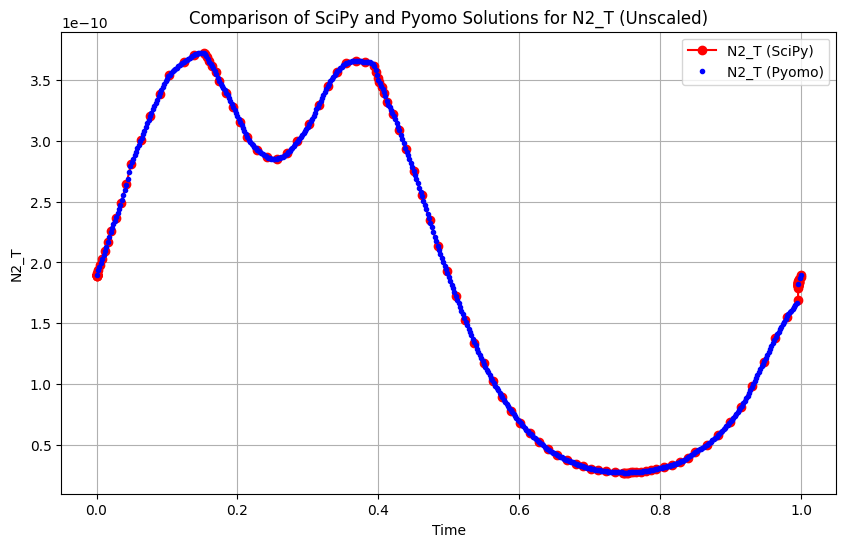

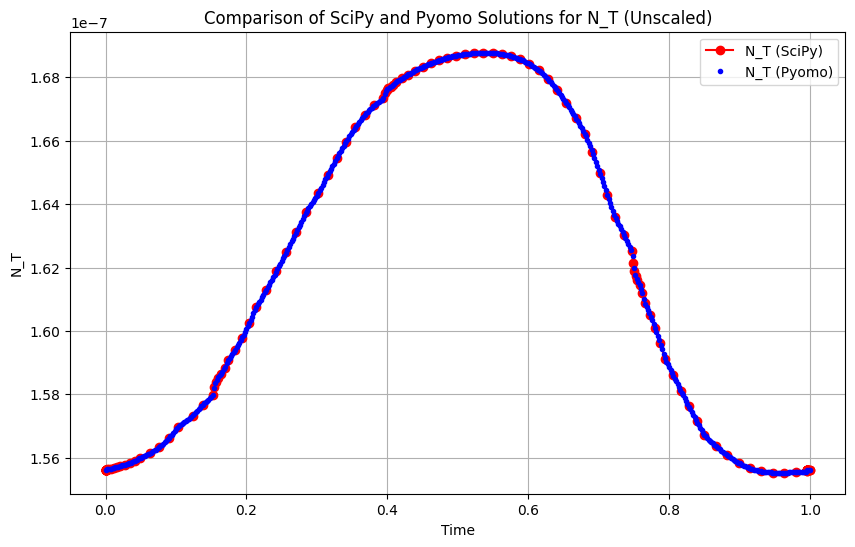

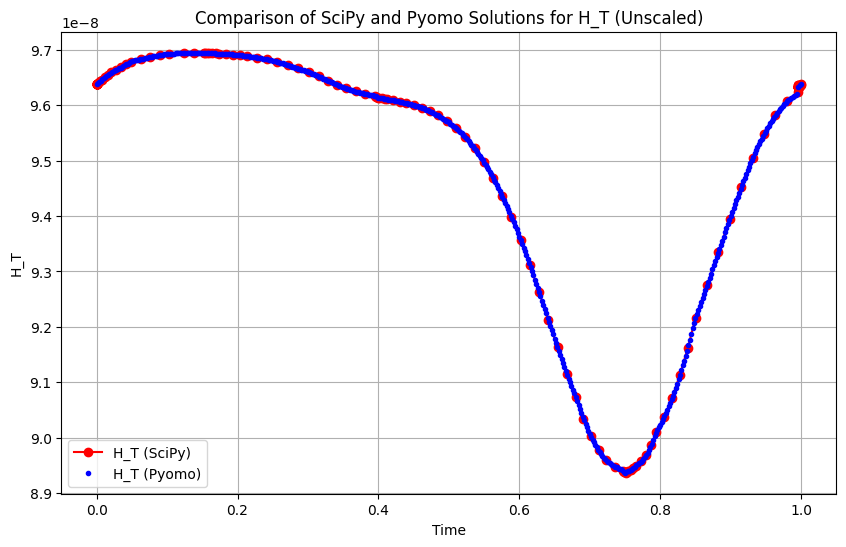

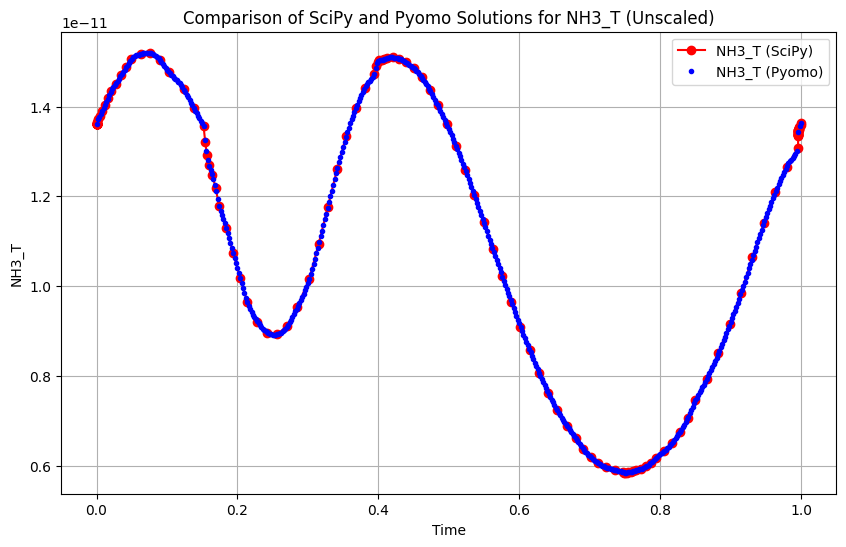

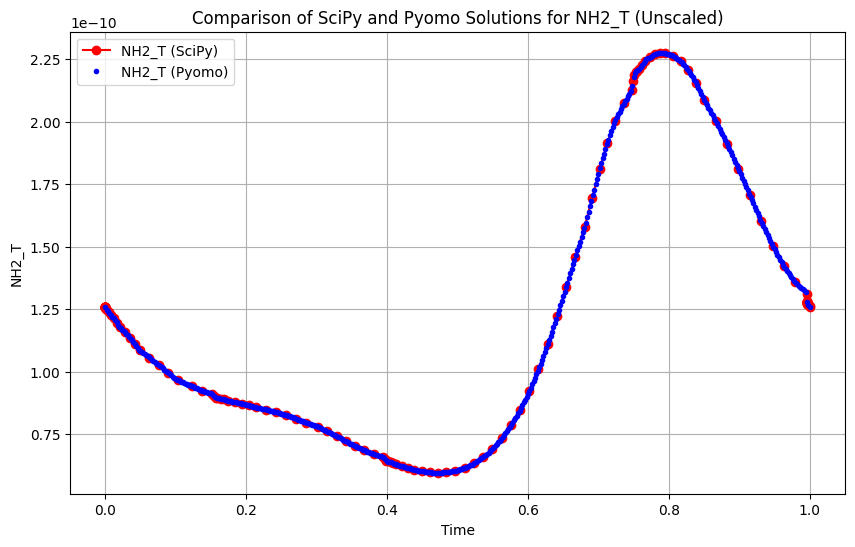

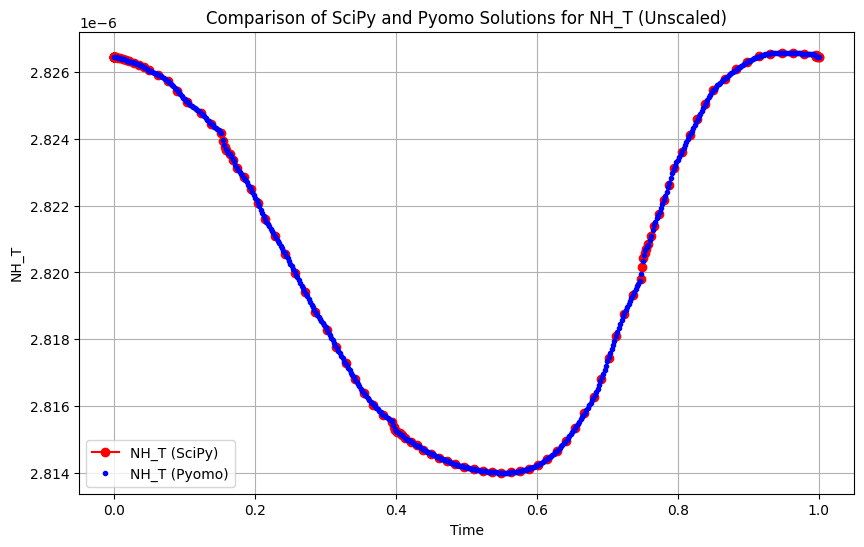

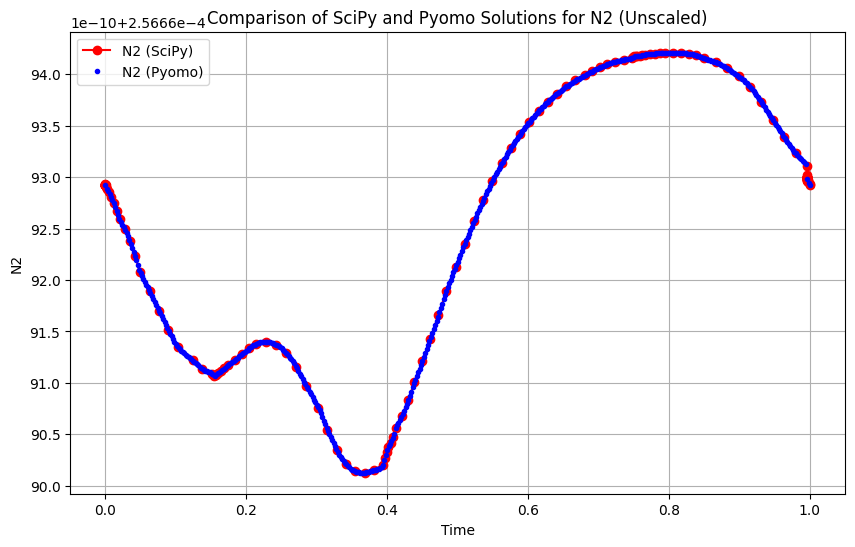

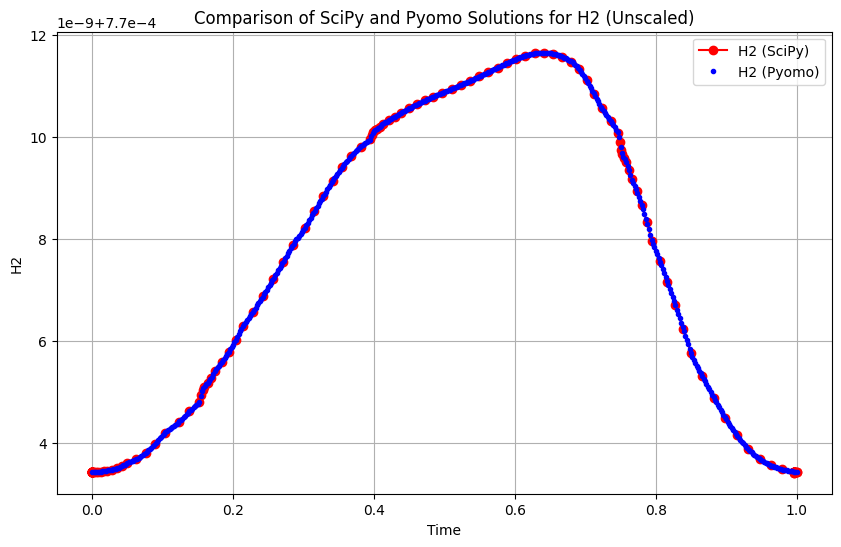

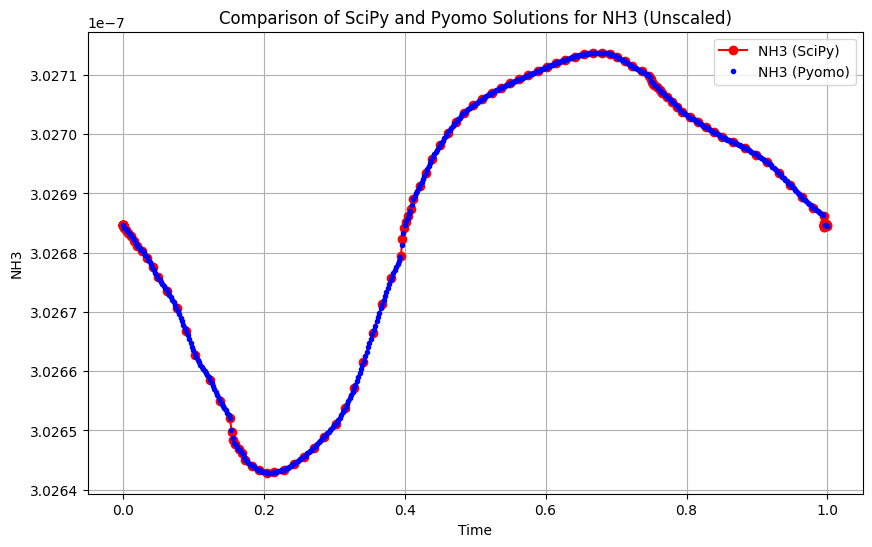

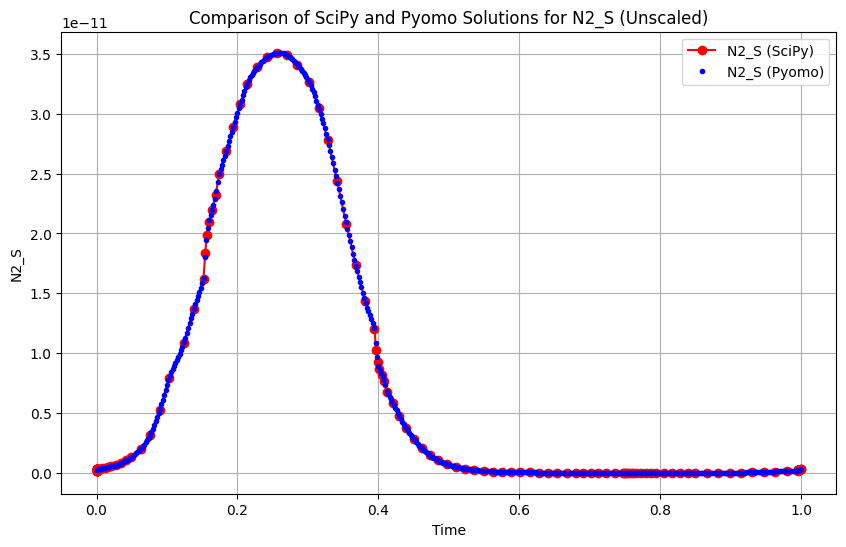

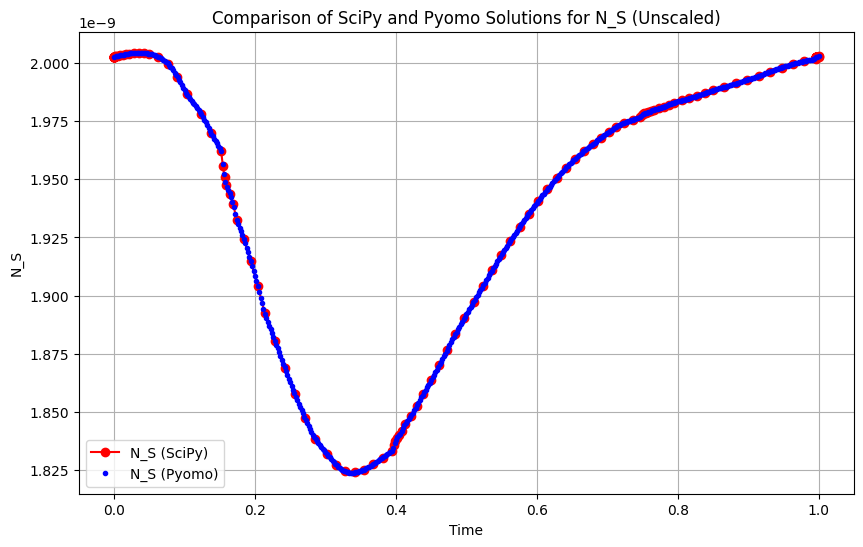

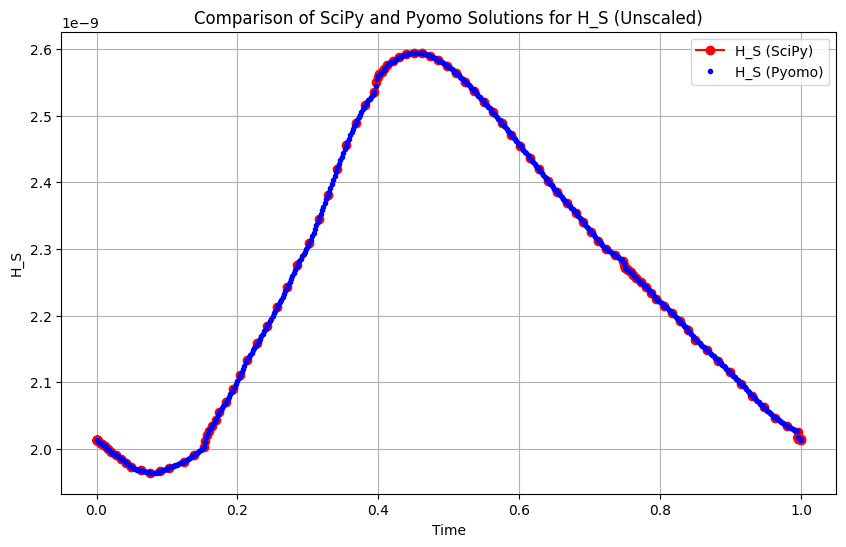

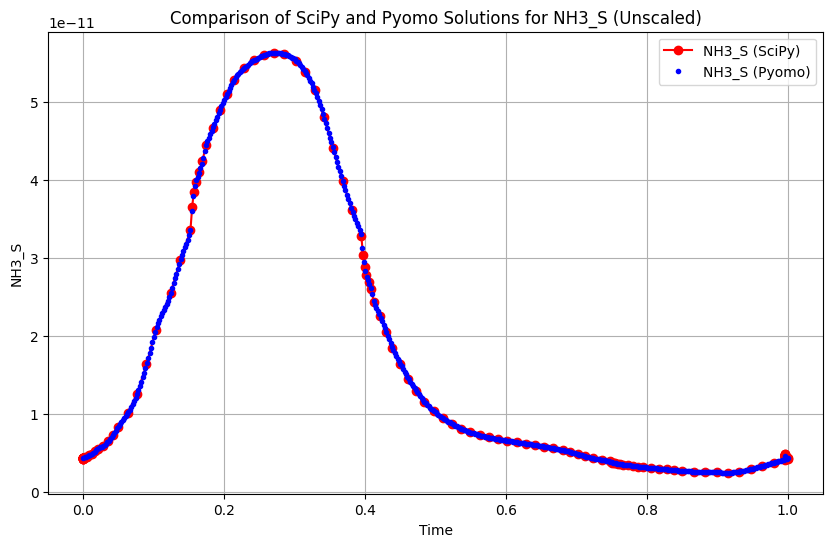

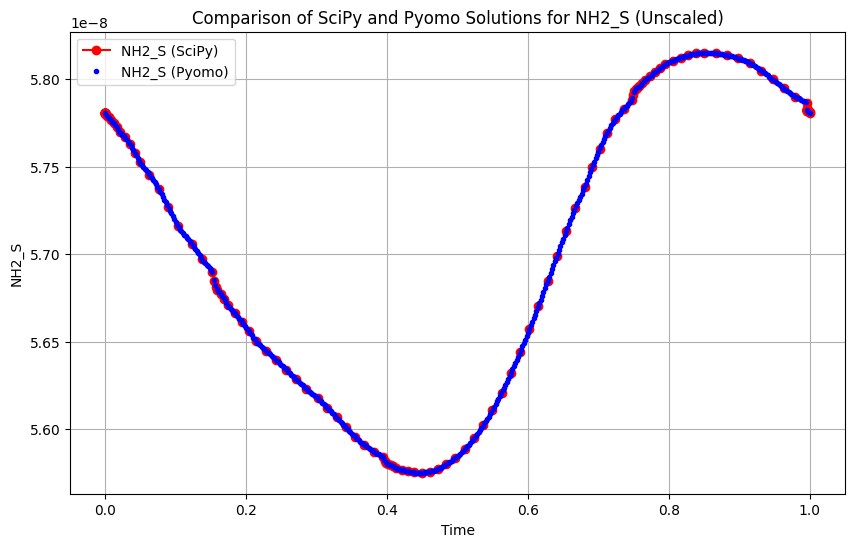

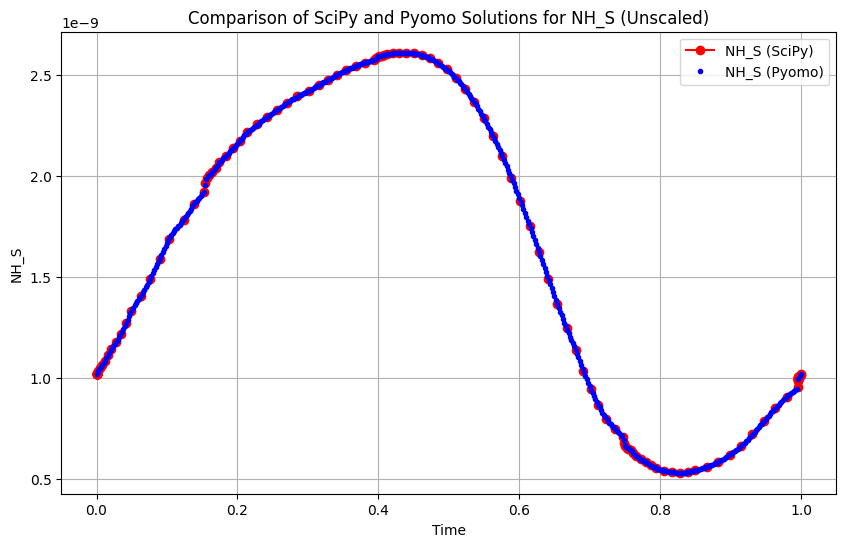

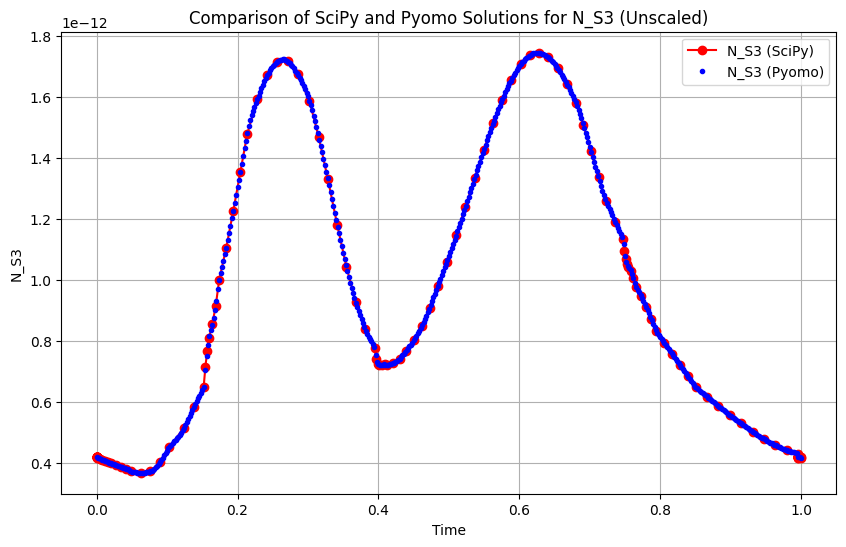

Ipopt 3.13.2: tol=1e-08


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. S

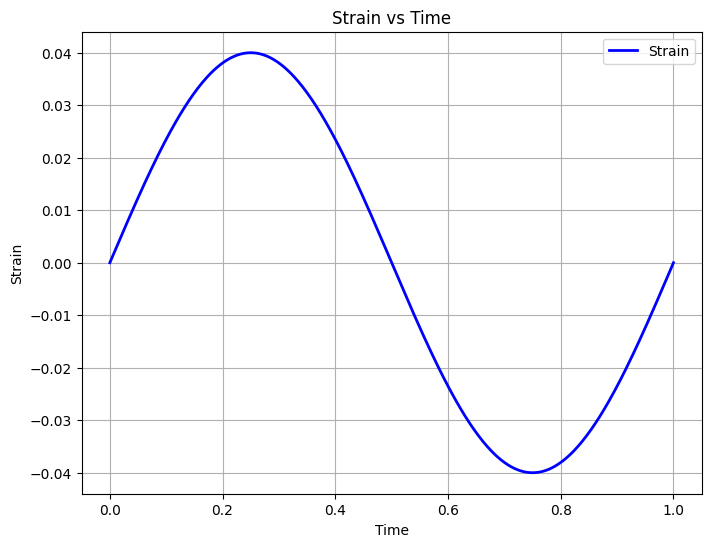

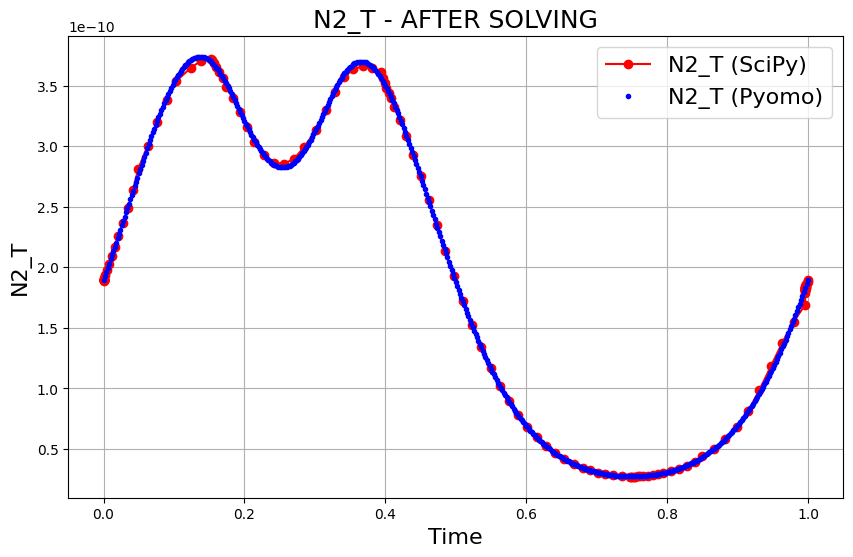

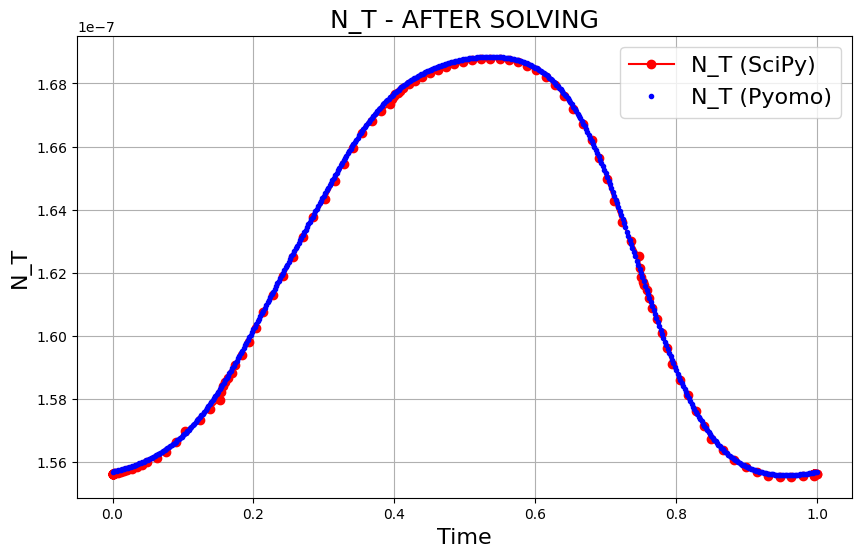

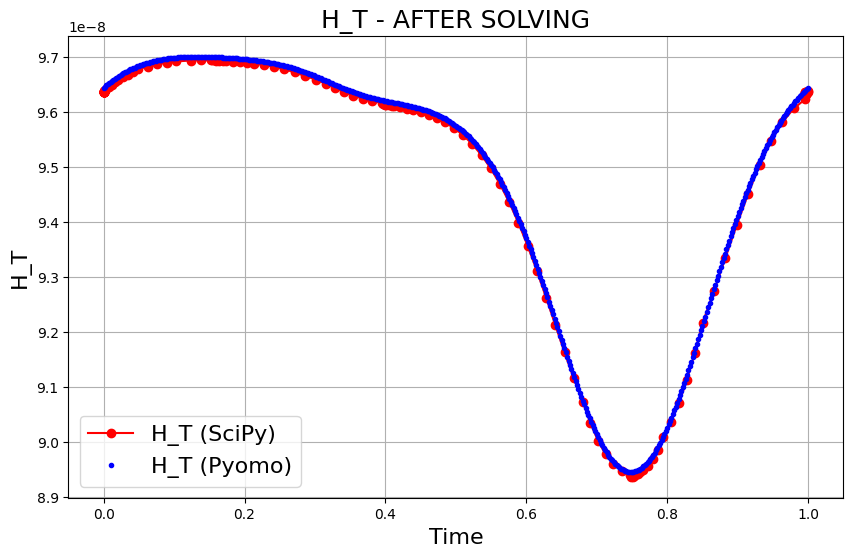

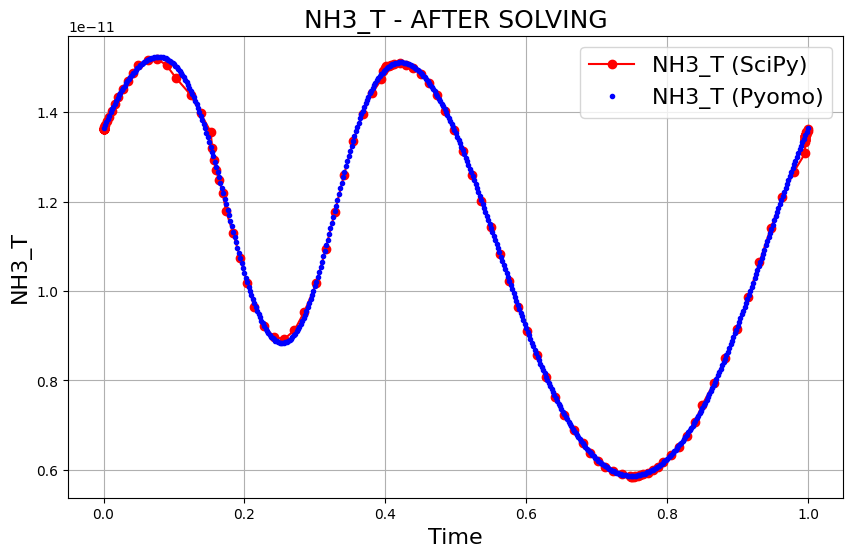

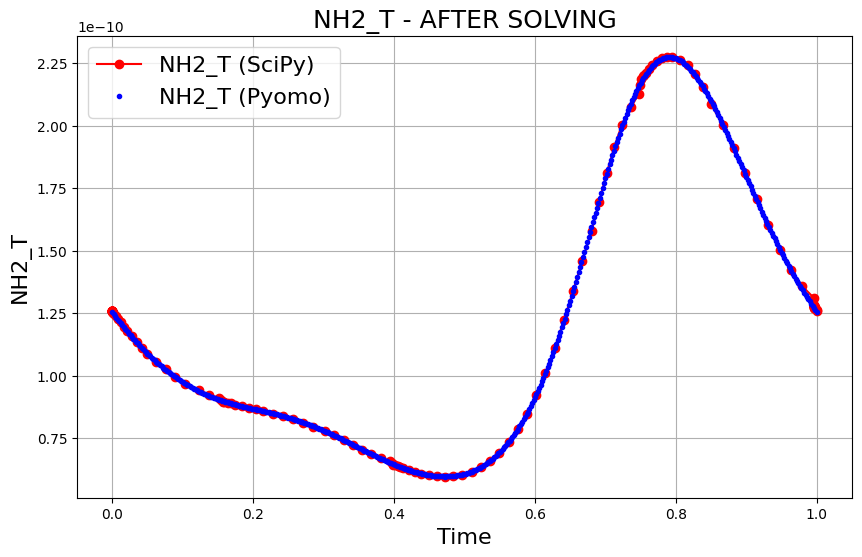

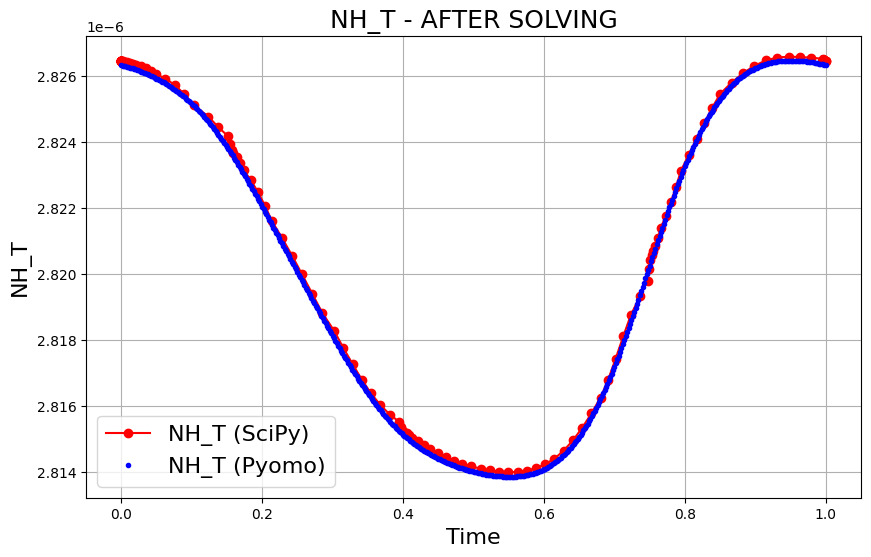

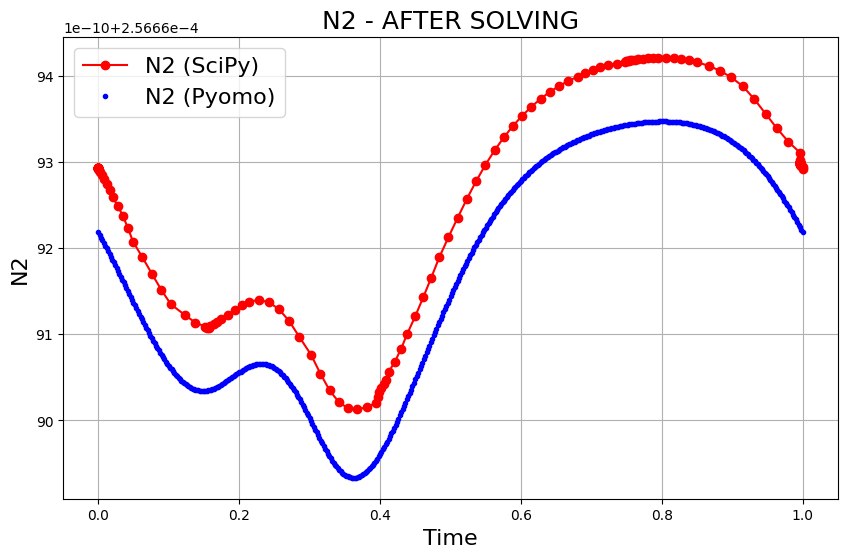

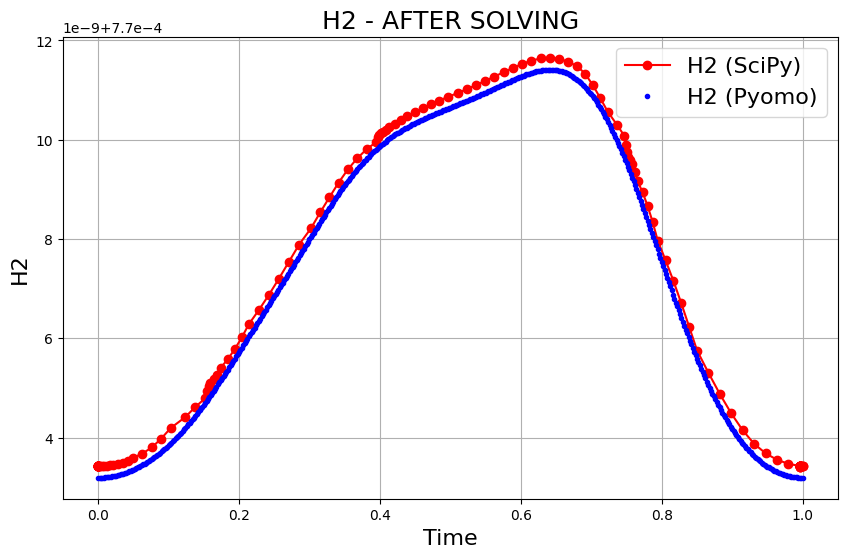

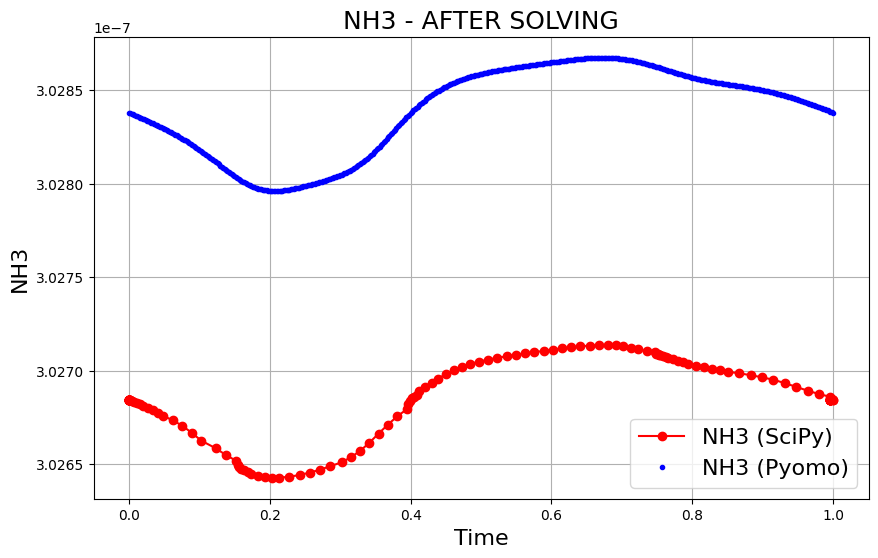

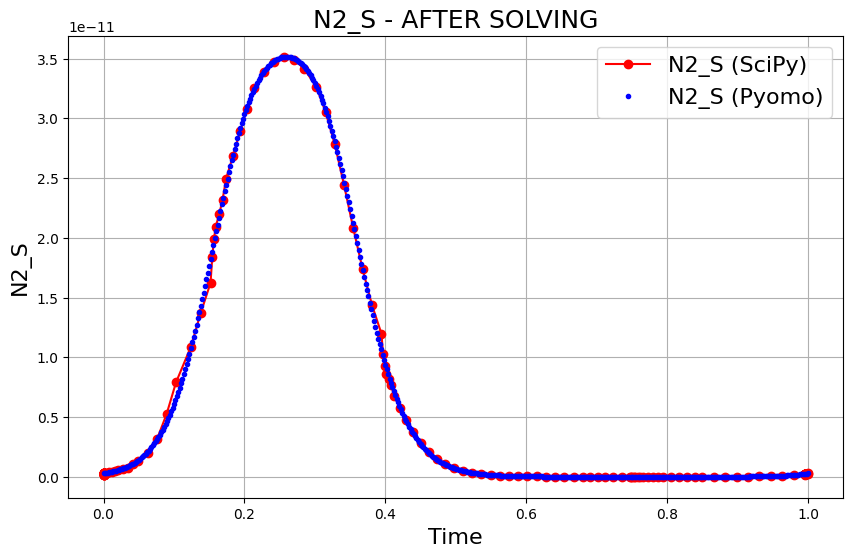

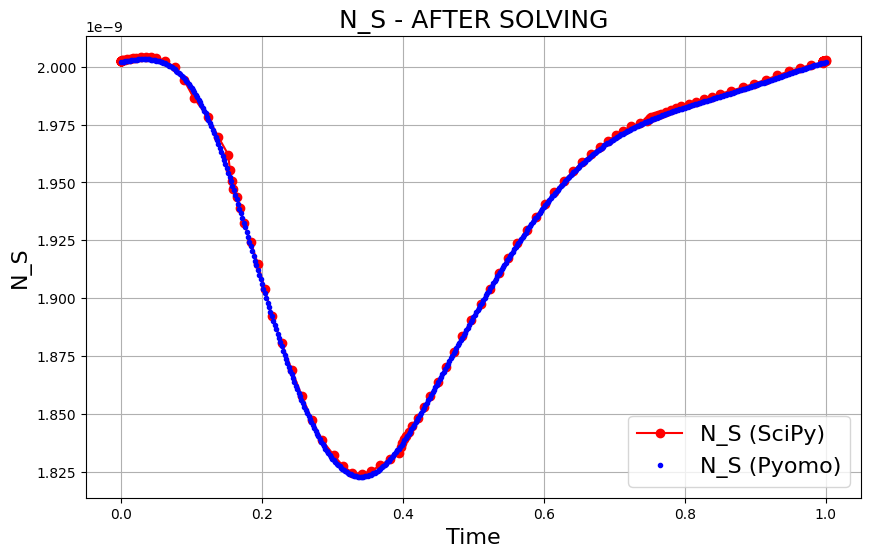

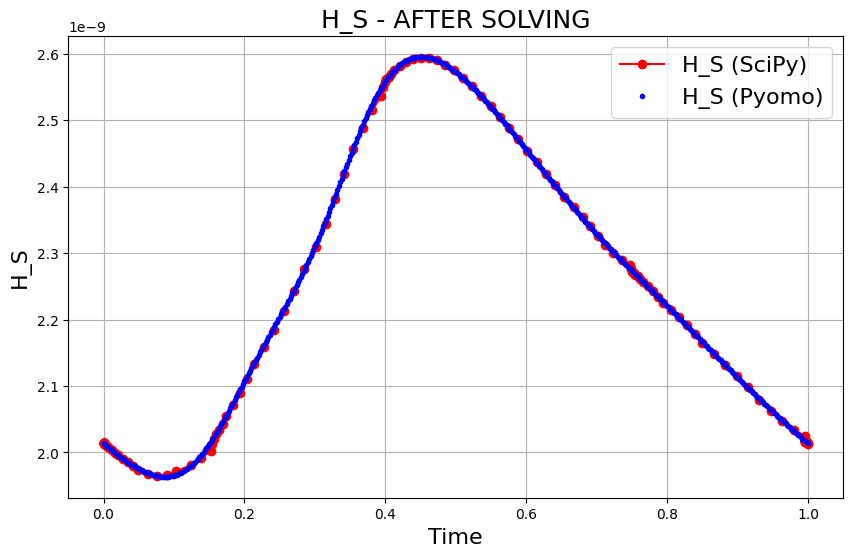

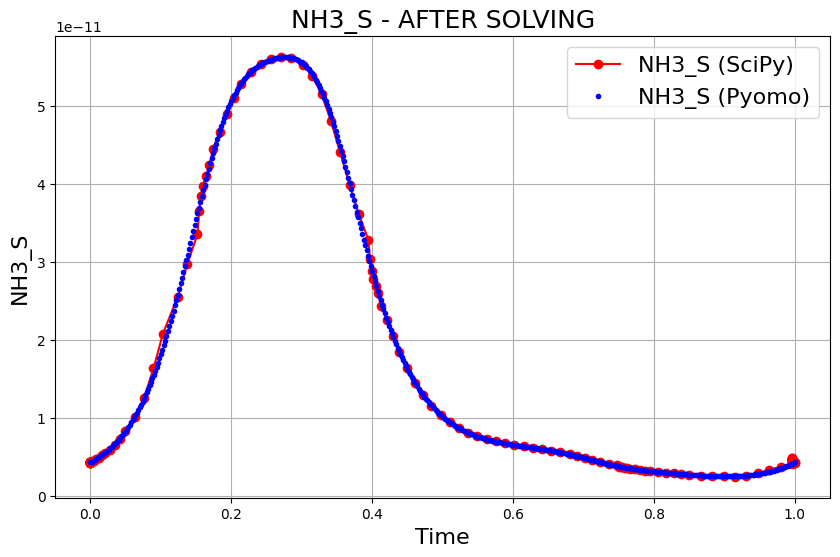

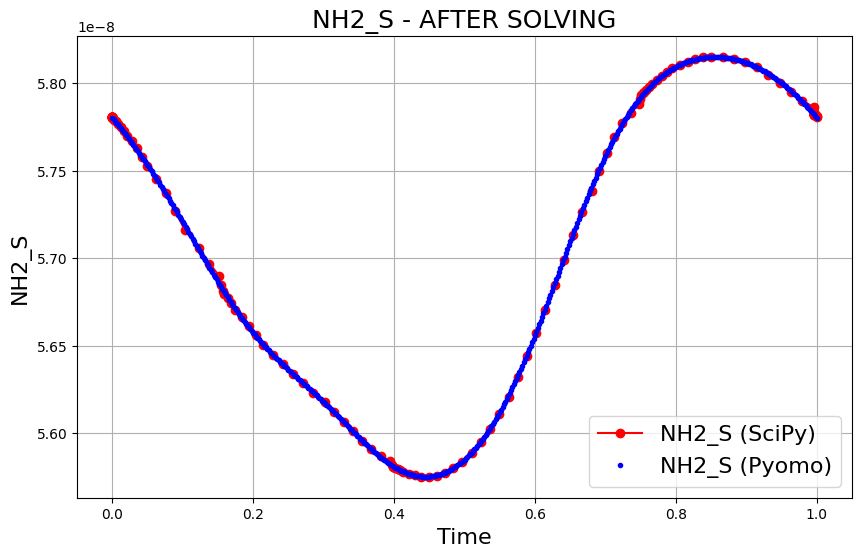

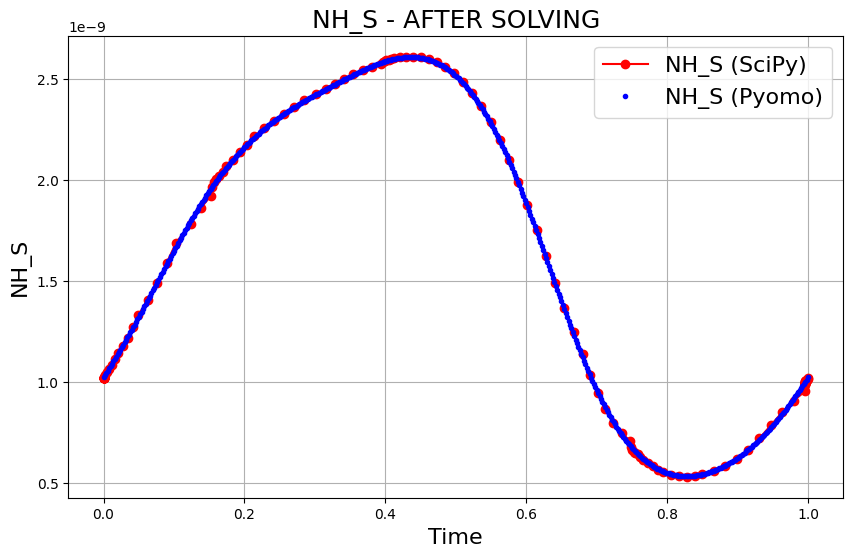

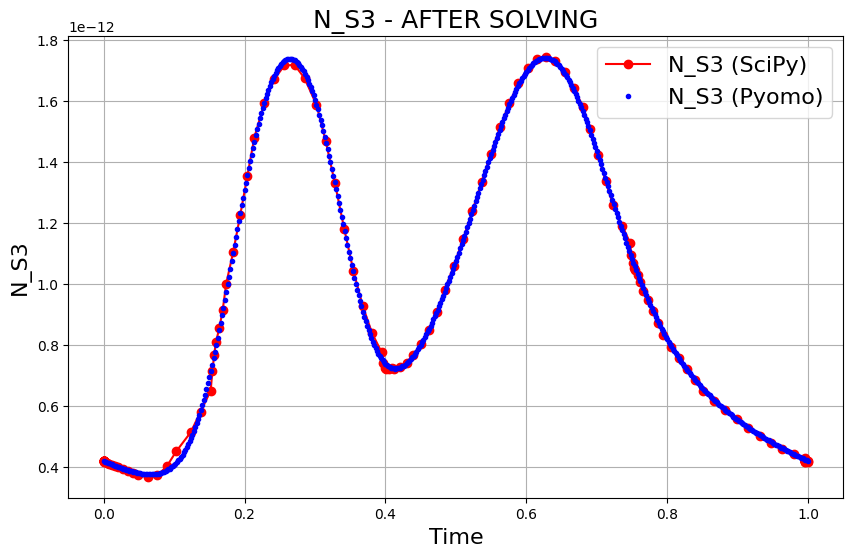

Shape of lhs_values: (16, 501)
Shape of rhs_values: (16, 501)


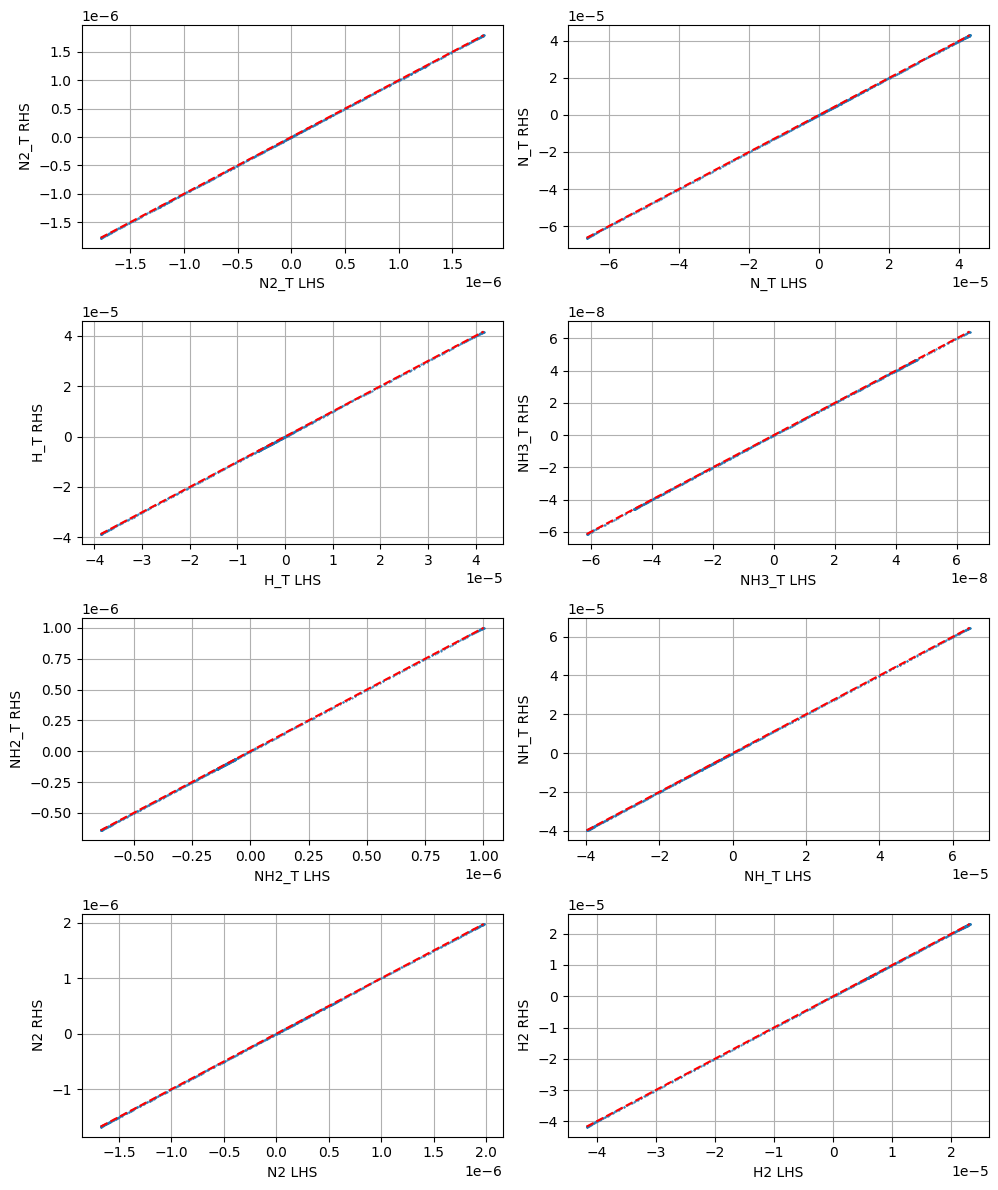

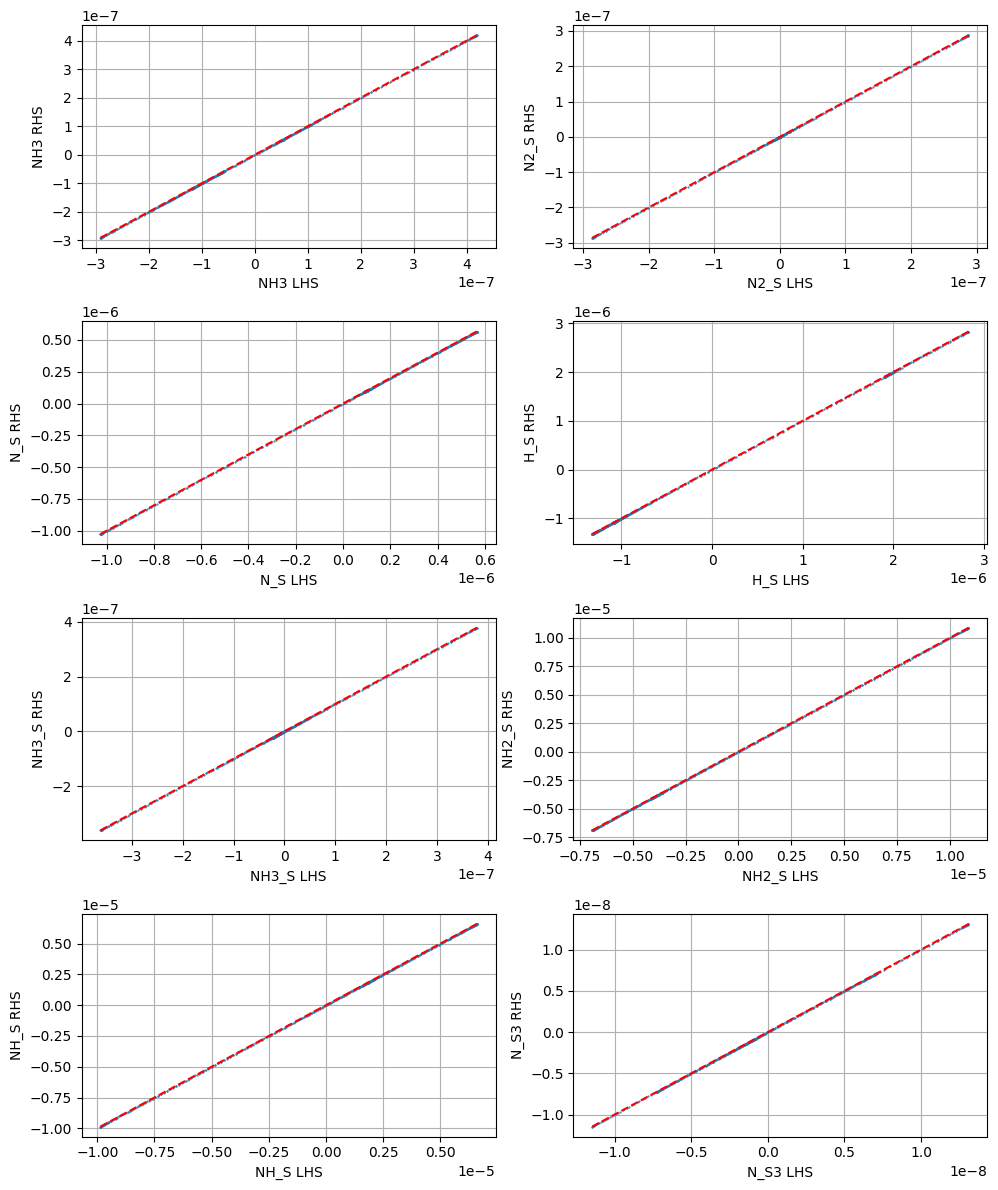

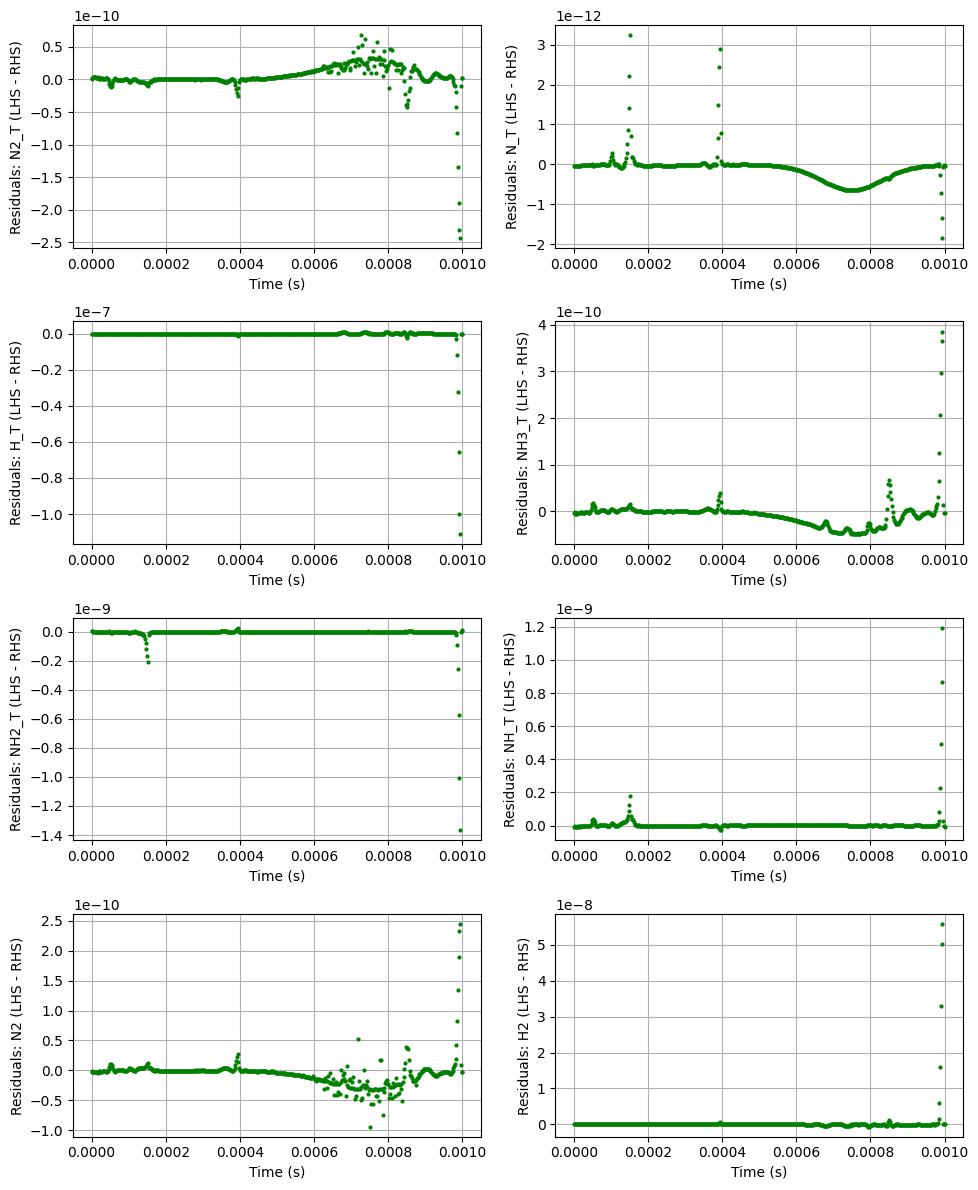

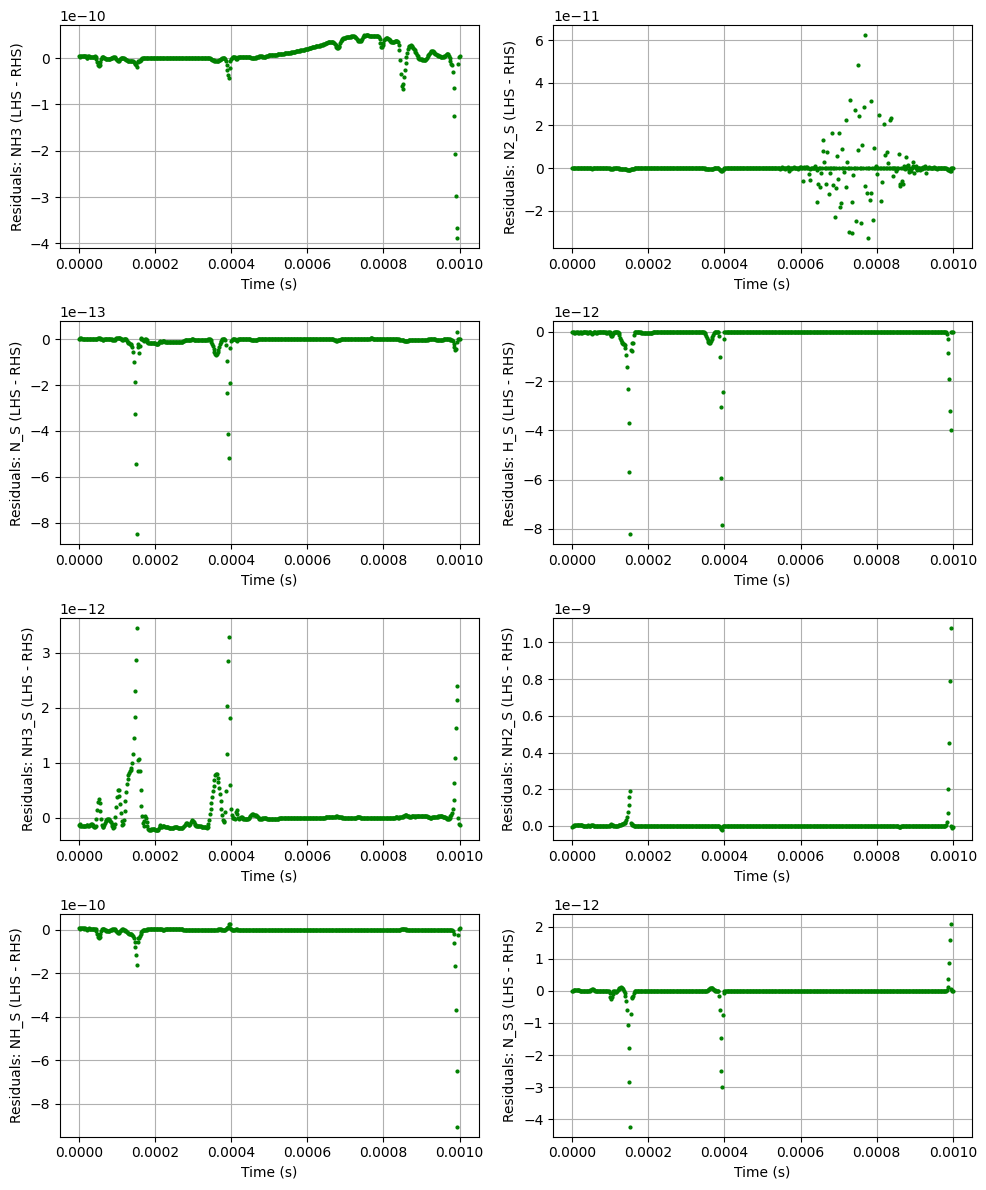

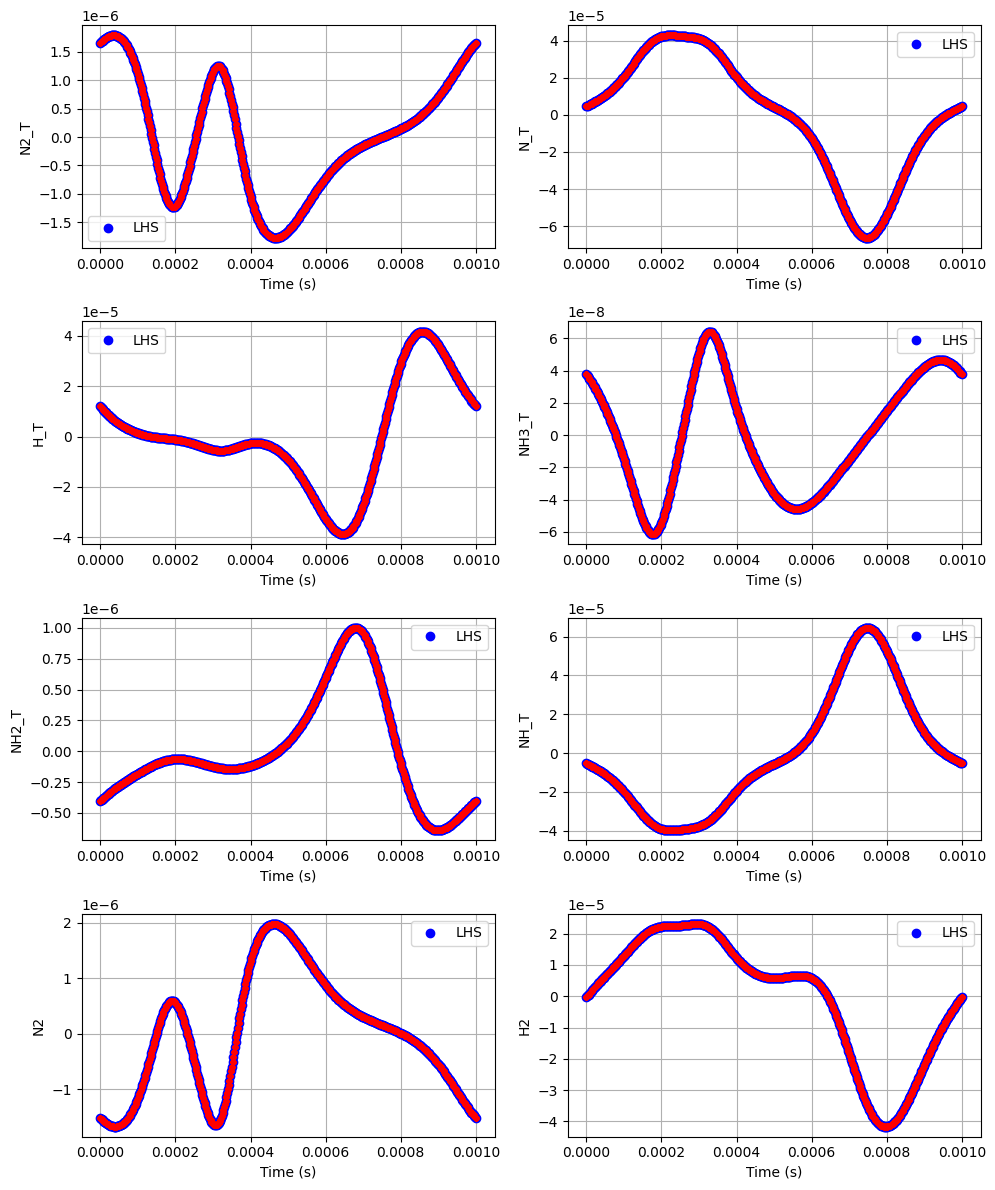

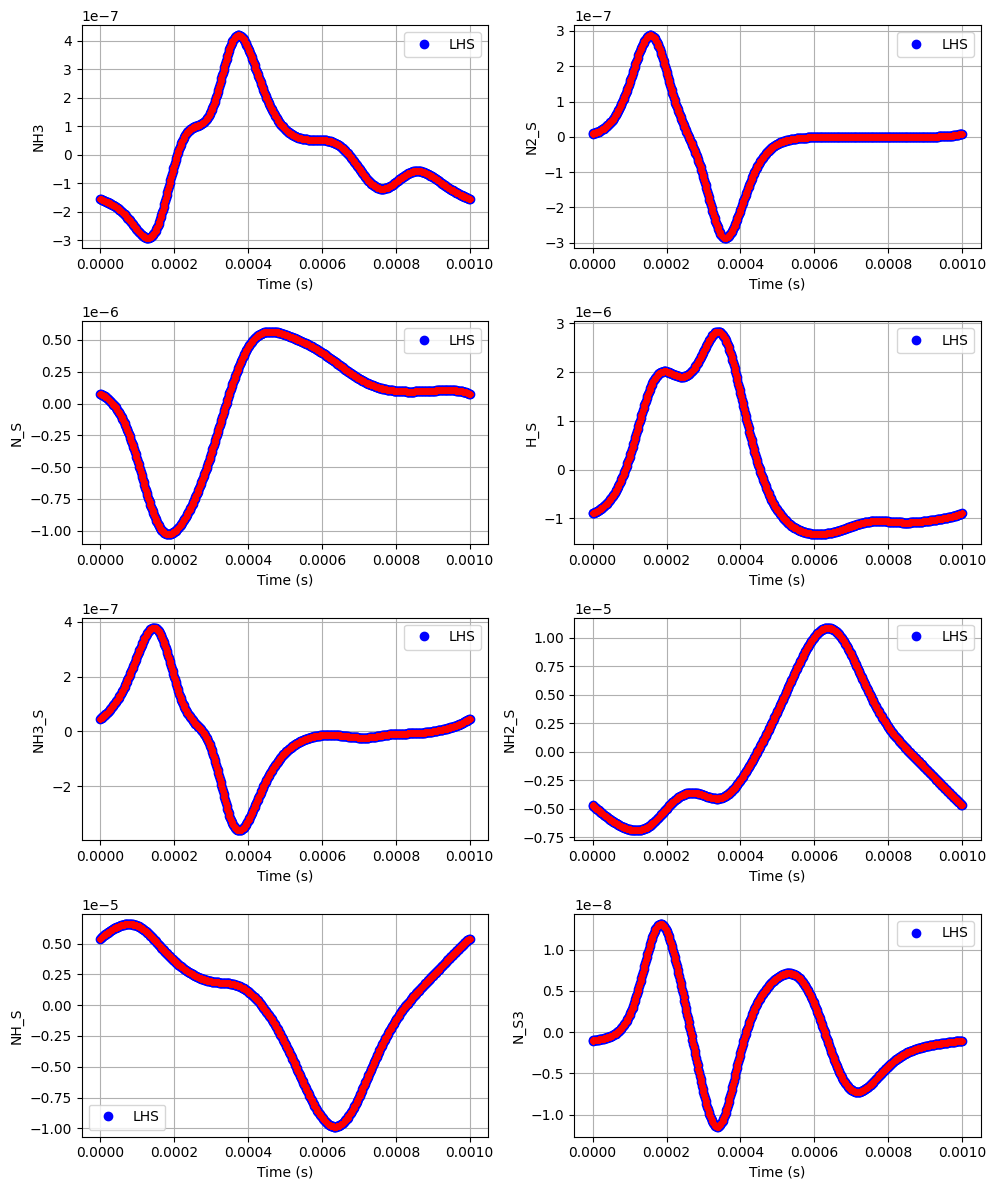

avTOF = 0.04818 Hz, run time = 32.52818 s.


In [29]:
# Gettings TOF array for plotting
start_time = time.time()

TOF, avTOF, N2, H2, NH3, pyomo_time, solution_pyomo = tof_from_decision_vars(params, tee=True)

end_time = time.time()

elapsed_time = end_time - start_time

print(f'avTOF = {avTOF:1.5f} Hz, run time = {elapsed_time:1.5f} s.')
# print(N2, H2, NH3)

In [30]:

variables = [
    "N2_T", "N_T", "H_T", "NH3_T", "NH2_T", "NH_T",
    "N2", "H2", "NH3", "N2_S", "N_S", "H_S",
    "NH3_S", "NH2_S", "NH_S", "N_S3"
]

residuals = [abs(a - b) for a, b in zip(solution_python, solution_pyomo)]

df = pd.DataFrame({
    "Variable": variables,
    "Solution IVP python": solution_python,
    "Solution IVP pyomo": solution_pyomo,
    "Residual": residuals
})

print('Comparison of last 200 out of total points of solutions')
print(df)

Comparison of last 200 out of total points of solutions
   Variable  Solution IVP python  Solution IVP pyomo      Residual
0      N2_T         1.924750e-10        1.916074e-10  8.675801e-13
1       N_T         1.597573e-07        1.622026e-07  2.445345e-09
2       H_T         9.514931e-08        9.472244e-08  4.268624e-10
3     NH3_T         1.185327e-11        1.086524e-11  9.880329e-13
4     NH2_T         1.238714e-10        1.189365e-10  4.934941e-12
5      NH_T         2.822545e-06        2.820159e-06  2.385994e-09
6        N2         2.566693e-04        2.566692e-04  8.944391e-11
7        H2         7.700062e-04        7.700075e-04  1.284598e-09
8       NH3         3.026854e-07        3.028392e-07  1.537873e-10
9      N2_S         4.936299e-12        7.962079e-12  3.025780e-12
10      N_S         1.959963e-09        1.934124e-09  2.583893e-11
11      H_S         2.174124e-09        2.264480e-09  9.035607e-11
12    NH3_S         1.320204e-11        1.846771e-11  5.265667e-12
13    